# Обработка неполных данных в деревьях решений

### **Цель работы**
Исследовать методы обработки пропущенных значений в табличных данных и реализовать модифицированное дерево решений, не игнорирующее наблюдени с пропусками. Провести сравнительный анализ предложенного метода с классическими деревьями решений и градиентным бустингом (XGBoost).

## Идея алгоритма
Во время разбиения по признаку, который отсутствует у наблюдения, добавлять наблюдение в обе формируемые ветви. Из-за этого вместо точного ответа будет получаться ответ вероятностный (как именно выбрать итоговый класс остаётся на личное усмотрение).

## Задачи
* Изучить существующие методы обработки неполных данных и типы пропусков.
* Реализовать класс `AdaptiveDecisionTreeClassifier` для дерева решений с обработкой пропусков (в качестве критерия разбиения Gini или энтропия, входные данные числовые).
* Провести сравнение предложенного метода с обычным деревом решений (`sklearn.tree.DecisionTreeClassifier`) и градиентным бустингом (`XGBoost`).
* Использовать учебные наборы данных (например, [Iris](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset), [Titanic](https://www.kaggle.com/datasets/yasserh/titanic-dataset), [Adult Income](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset), любые другие табличные наборы для классификации).
* Оценить влияние пропусков на качество моделей, используя метрики (Accuracy, F1-score).


## Ожидаемые результаты
* Теоретический обзор (краткое описание методов).
* Код реализации дерева решений.
* Графики / таблицы, демонстрирующие результаты сравнения.
* Выводы о преимуществах и недостатках предложенного метода.

## Требования к реализации
* Код должен быть написан на Python версии 3.9 и выше.
* Рекомендуемые библиотеки: `numpy`, `pandas`, `scikit-learn`, `xgboost`, `matplotlib`).
* Стиль кода соответствует PEP8.
* Реализация дерева решений должна быть в виде отдельного класса с методами `fit`, `predict`.
* Датасеты и код для экспериментов должны быть воспроизводимыми.

## Заготовка класса:

```python
import numpy as np


class AdaptiveDecisionTreeClassifier:
   def __init__(self, criterion: str = "gini", min_samples_split: int = 2, min_samples_leaf: int = 1):
      pass

   def fit(self, x: np.ndarray, y: np.array) -> "AdaptiveDecisionTreeClassifier":
      pass

   def predict(self, x: np.ndarray) -> np.array:
      pass

   def get_depth(self) -> int:
      pass
```

## Краткая теоретическая справка

##### **Дерево решений** — алгоритм машинного обучения, используемый для задач классификации и регрессии. Реализует иерархическую структуру узлов, где каждый узел проверяет условие на атрибуте, чтобы разделить данные на ветви.  
---
### Методы поиска лучшего разделения в узле
#### 1. Критерий Джини
**Критерий Джини** измеряет неоднородность в узле.  
Формула для узла:  
$$
G = 1 - \sum_{i=1}^{n} p_i^2
$$  
где $p_i$ — доля объектов класса i в узле.

- **Чем ниже значение Джини**, тем чище узел.   

Алгоритм выбирает разбиение, которое **минимизирует суммарный критерий Джини** для дочерних узлов.

**Взвешенная неоднородность** после разбиения на левую $L$ и правую $R$ ветви:
$$
G_{\text{weighted}} = \frac{W_L \cdot G_L + W_R \cdot G_R}{W_L + W_R}
$$
где $W_L, W_R$ — суммарные веса объектов в левой и правой ветвях.

#### 2. Критерий энтропии
**Энтропия** оценивает хаотичность в узле.  
Формула:  
$$
H = -\sum_{i=1}^{n} p_i \cdot \log_2(p_i)
$$  

- **Чем ниже энтропия**, тем однороднее узел (если все объекты принадлежат одному классу H = 0).  

Алгоритм стремится к **минимизации энтропии**.

**Взвешенная энтропия** после разбиения:
$$
H_{\text{weighted}} = \frac{W_L \cdot H_L + W_R \cdot H_R}{W_L + W_R}
$$

---

### Сравнение
- **Джини**:  
  - Быстрее вычисляется
  - Чаще используется в библиотеках

- **Энтропия**:  
  - Сильнее штрафует узлы с неравномерным распределением.  
  - Создает более сбалансированные деревья.  

На практике разница в качестве моделей между ними часто незначительна.

---

### Виды пропущенных данных

Пропуски данных — это отсутствующие значения в наборе данных, которые могут появляться по разным причинам. В статистике и анализе данных пропуски классифицируются на три основных типа в зависимости от механизма их возникновения.


#### 1. Missing Completely at Random (MCAR)
Пропуски данных считаются **Missing Completely at Random (MCAR)**, если вероятность их появления не зависит ни от наблюдаемых данных, ни от самих пропущенных значений. Это означает, что пропуски возникают абсолютно случайно и не связаны с какими-либо закономерностями в данных.

**Пример:**  
В анкете о доходах некоторые участники пропустили вопрос о доходе из-за случайной ошибки при заполнении или сборе данных. Пропуск не связан ни с их доходом, ни с другими характеристиками, такими как возраст или пол.

**Последствия для анализа:**  
- Пропуски MCAR не приводят к систематическому искажению результатов анализа, если их доля невелика.
- Их можно обрабатывать простыми методами, например, удалением строк с пропусками или заменой пропущенных значений на среднее по выборке.

#### 2. Missing at Random (MAR)
 Пропуски данных считаются **Missing at Random (MAR)**, если вероятность их возникновения зависит от других наблюдаемых данных, но не от самих пропущенных значений. Пропуски можно объяснить с помощью доступных переменных в наборе данных.

**Пример:**  
В опросе о доходах мужчины чаще пропускают вопрос о доходе, чем женщины. Здесь вероятность пропуска зависит от пола (наблюдаемой переменной), но не от величины дохода.

**Последствия для анализа:**  
- Пропуски MAR можно обработать, используя информацию из наблюдаемых данных, например, с помощью стратифицированной импьютации (замена пропусков средним значением в зависимости от пола) или моделирования.
- Игнорирование зависимости от наблюдаемых данных может привести к смещению результатов.


#### 3. Missing Not at Random (MNAR)
Пропуски данных считаются **Missing Not at Random (MNAR)**, если вероятность их появления зависит от самих пропущенных значений или от других ненаблюдаемых факторов. Это наиболее сложный тип пропусков, так как их нельзя полностью объяснить с помощью доступных данных.

**Пример:**  
Люди с высоким доходом чаще отказываются сообщать свой доход в анкете. В этом случае пропуски напрямую зависят от величины дохода — пропущенного значения.

**Последствия для анализа:**  
- Пропуски MNAR могут существенно искажать результаты анализа, так как отсутствующие значения систематически отличаются от наблюдаемых.
- Для их обработки требуются сложные методы, такие как моделирование механизма пропусков или проведение чувствительного анализа для оценки влияния пропусков.
---

### Методы обработки пропущенных значений

##### 1. Удаление
Метод предполагает удаление всех строк, содержащих хотя бы одно пропущенное значение. Это простой подход, часто используемый в начальных этапах анализа данных.

**Преимущества:**
- Простота реализации, не требует дополнительных вычислений.
- Не требует предположений о природе пропущенных значений.

**Недостатки:**
- Может привести к значительной потере данных, особенно если пропуски распространены.
- Может привести к смещению модели, если данные не пропущены случайно (MCAR).


##### 2. Импьютация
Замена пропущенных значений на оценочные значения, основанные на доступных данных. Включает:
- **Среднее значение:** Для числовых признаков заменяет пропуски на среднее значение признака.
- **Медиана:** Аналогично, но использует медиану, что может быть лучше при наличии выбросов.
- **Мода:** Для категориальных признаков заменяет пропуски на наиболее частое значение.
- Более продвинутые методы, такие как импьютация на основе k-ближайших соседей или регрессионные модели.

**Преимущества:**
- Сохраняет все данные, избегая потери информации.
- Простота реализации для базовых методов, таких как среднее или мода.

**Недостатки:**
- Может ввести смещение, особенно если данные не пропущены случайно (MAR или MNAR).
- Не всегда точно отражает вариабельность данных, особенно для сложных распределений.


##### 3. Обработка пропусков как отдельной категории
Пропущенные значения рассматриваются как еще одна возможная категория для признака. Для категориальных признаков это означает добавление категории "пропущено". Для числовых признаков можно назначить специальное значение, например, -1, и создать отдельную ветвь в дереве.

**Преимущества:**
- Позволяет напрямую обрабатывать пропуски без предварительной импьютации.
- Дерево решений может научиться различать паттерны, связанные с пропусками, если они имеют значение (пропуски могут указывать на отсутствие информации, что само по себе информативно).

**Недостатки:**
- Предполагает, что пропуски образуют отдельную группу, что может быть неверно, если пропуски случайны.
- Может усложнить дерево, особенно если много признаков имеют пропуски, что увеличивает его размер и сложность.

##### 4. Пропорциональное распределение (метод C4.5/C5)
Когда признак, используемый для разделения, имеет пропущенные значения, экземпляры с пропусками распределяются по дочерним узлам на основе пропорций экземпляров с известными значениями в каждом узле. Например, если 60% известных значений идут в левый дочерний узел, то экземпляр с пропуском имеет 60% вероятность быть отнесенным туда.

**Преимущества:**
- Обрабатывает пропуски без необходимости предварительной импьютации.
- Сохраняет распределение известных значений, что может быть полезно для сохранения структуры данных.

**Недостатки:**
- Может быть неточным, если пропуски не случайны (MAR или MNAR), так как распределение может быть искажено.
- Может быть вычислительно затратным для больших наборов данных, особенно при глубоких деревьях.

##### 5. Суррогатные сплиты (метод CART)
Когда признак, используемый для разделения, имеет пропущенные значения, алгоритм находит другой признак, который имеет схожое поведение разделения (суррогатный сплит), и использует его для определения, в какой дочерний узел направить экземпляр с пропуском.

**Преимущества:**
- Обрабатывает пропуски без импьютации, сохраняя целостность данных.
- Может быть полезно, если суррогатный признак хорошо коррелирует с основным.

**Недостатки:**
- Вычислительно затратно, так как требует поиска подходящего суррогатного признака.
- Может не всегда найти подходящий суррогат, особенно если признаки слабо коррелируют.

##### 6. Вероятностные методы (на основе статьи https://arxiv.org/pdf/2006.16341)
В статье "Handling Missing Data in Decision Trees: A Probabilistic Approach" предлагается использовать вероятностные модели для предсказания пропущенных значений на основе доступных данных. Это может включать:
- **Байесовские сети:** Моделирование зависимостей между признаками для предсказания пропущенных значений.
- **Марковские цепи Монте-Карло (MCMC):** Использование случайных процессов для оценки пропущенных значений.
- **Методы глубокого обучения:** Использование нейронных сетей для предсказания пропущенных значений.

**Преимущества:**
- Высокая точность предсказания пропущенных значений, особенно при наличии сложных зависимостей.
- Способность обрабатывать различные типы пропусков (MCAR, MAR, MNAR).

**Недостатки:**
- Высокая вычислительная сложность, что может быть проблематично для больших наборов данных.
- Требует оценки распределений, что увеличивает вычислительную сложность.
- Реализация сложнее, чем у традиционных методов, таких как удаление или импьютация.

##### Методы и идеи из статьи 6.
В статье авторы предлагают вероятностный подход к обработке пропущенных значений, основанный на моделировании совместного распределения данных. Основные методы включают:
- **Missingness-Incorporated Attribute (MIA):** Пропущенные значения включаются в процесс построения дерева через добавление индикатора пропущенности как части атрибута. Например, для числового признака x  создается новый атрибут (x, m) , где m = 1, если значение пропущено, и m = 0, если значение известно.
- **Probabilistic Splitting:** Вместо детерминированного распределения экземпляров с пропущенными значениями (как в C4.5), используется вероятностное разделение, основанное на оценке апостериорного распределения P(x | y, D), где x — пропущенный атрибут, y  — целевая переменная, а D  — данные.
- **Imputation with Uncertainty:** Выполняется импьютация пропущенных значений с учетом неопределенности, используя выборку из распределения P(x |y, D).

---


## найденные источники

https://loginom.ru/blog/decision-tree-c45-2

https://habr.com/ru/companies/productstar/articles/523044/

https://arxiv.org/pdf/2006.16341

#### Предложенное решение является схожим с методом C4.5

## имопрт библиотек

In [2]:
import pandas as pd
import numpy as np
from abc import ABC, abstractmethod
from copy import copy, deepcopy

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.tree import export_text
from sklearn.datasets import load_wine

import xgboost as xgb


from joblib import Parallel, delayed

import matplotlib.pyplot as plt

from pyampute import MultivariateAmputation

from itertools import combinations

## Модиффицированное дерево решений

In [3]:
class Criterion(ABC):
    @staticmethod
    @abstractmethod
    def compute(x: np.ndarray, y: np.ndarray, y_probs: np.ndarray, min_samples_leaf: int) -> tuple:
        '''finds the best attribute and threshold based on the data using the criterion'''
        pass

    @staticmethod
    def _compute_common(criterion_func, x: np.ndarray, y: np.ndarray, y_probs: np.ndarray, min_samples_leaf: int) -> tuple:
        '''the part that is common to all criteria in the calculation and search best attribute is included in a separate method'''
        best_criterion = float('inf')
        best_threshold = None
        best_feature = -1
        prob_right = None
        #going through all the attributes to found best threshold
        for feature_idx in range(x.shape[1]):
            x_atr = x[:, feature_idx]
            threshold_temp, criterion_temp = criterion_func(x_atr, y, y_probs, min_samples_leaf)
            if threshold_temp is None:
                continue
            if criterion_temp < best_criterion:
                
                best_criterion = criterion_temp
                best_threshold = threshold_temp
                best_feature = feature_idx

                #finding the probability of hitting the right branch is used in prediction for missing data
                non_nan_mask = ~np.isnan(x_atr.astype(float))
                x_atr_non_nan = x_atr[non_nan_mask]
                y_probs_non_nan = y_probs[non_nan_mask]
                mask = x_atr_non_nan > best_threshold
                total_weight = np.sum(y_probs_non_nan) + 1e-10
                prob_right = np.sum(y_probs_non_nan[mask]) / total_weight

        return best_feature, best_threshold, best_criterion, prob_right

    @staticmethod
    def _compute_common_impurity(x_atr, y, y_probs, min_samples_leaf, impurity_func, parent_impurity_func, eps=1e-10):
        '''the part that is common to all criteria in the calculation and search best threshold for specific attribute'''
        non_nan = ~np.isnan(x_atr.astype(float))
        x_clean = x_atr[non_nan]
        y_clean = y[non_nan]
        probs_clean = y_probs[non_nan]

        #checking for a stop
        if len(x_clean) < 2 or len(np.unique(y_clean)) < 2:
            return None, parent_impurity_func(y_clean, probs_clean, eps)

        if np.all(x_clean == x_clean[0]):
            return None, parent_impurity_func(y_clean, probs_clean, eps)

        #getting clean data
        order = np.argsort(x_clean)
        x_sorted = x_clean[order]
        y_sorted = y_clean[order]
        probs_sorted = probs_clean[order]

        #cumulative weights/probabilities
        cum_probs = np.cumsum(probs_sorted)
        total_probs = cum_probs[-1]

        #creating a matrix in which each row corresponds to a unique class and in each row
        # the cumulative probabilities of belonging to a particular class are recorded
        
        classes = np.unique(y_clean)
        cum_class_probs = np.vstack([np.cumsum((y_sorted == cls) * probs_sorted) for cls in classes])

        left_probs = cum_probs[:-1]
        right_probs = total_probs - left_probs

        #checking for a stop
        valid = (left_probs >= min_samples_leaf) & (right_probs >= min_samples_leaf)
        if not valid.any():
            return None, parent_impurity_func(y_clean, probs_clean, eps)

        parent_impurity = parent_impurity_func(y_clean, probs_clean, eps)
        #the probability of belonging to a class is divided by the total probability
        p_left = cum_class_probs[:, :-1] / (left_probs.reshape(1, -1) + eps)
        impurity_left = impurity_func(p_left, eps)

        p_right = (cum_class_probs[:, -1, None] - cum_class_probs[:, :-1]) / (right_probs.reshape(1, -1) + eps)
        impurity_right = impurity_func(p_right, eps)

        total_impurity = (impurity_left * left_probs + impurity_right * right_probs) / total_probs

        gain = parent_impurity - total_impurity
        total_impurity[~valid] = np.inf
        total_impurity[gain <= 1e-2] = np.inf

        #checking for a stop
        if np.all(np.isinf(total_impurity)):
            return None, parent_impurity

        best_idx = np.argmin(total_impurity)
        best_threshold = (x_sorted[best_idx] + x_sorted[best_idx + 1]) / 2
        return best_threshold, total_impurity[best_idx]

class CriterionGini(Criterion):
    @staticmethod
    def gini(x_atr: np.ndarray, y: np.ndarray, y_probs: np.ndarray, min_samples_leaf: int) -> tuple:
        def impurity_func(p: np.ndarray, eps: float):
            '''for a conditional probability matrix in which each row contains\
                probabilities for a separate class, a criterion is calculated for each threshold'''
            return 1 - np.sum(p**2, axis=0)
        def parent_impurity_func(y_clean, probs_clean, eps):
            '''The criterion for the parent node is calculated. It is necessary to calculate the gain'''
            counts = np.bincount(y_clean, weights=probs_clean)
            total = np.sum(counts) + eps
            p_parent = counts / total
            return 1 - np.sum(p_parent**2)
        return Criterion._compute_common_impurity(
            x_atr, y, y_probs, min_samples_leaf, impurity_func, parent_impurity_func, eps=1e-10
        )

    @staticmethod
    def compute(x: np.ndarray, y: np.ndarray, y_probs: np.array, min_samples_leaf: int) -> tuple:
        '''finds the best attribute and threshold based on the data using the criterion'''
        return Criterion._compute_common(CriterionGini.gini, x, y, y_probs, min_samples_leaf)

class CriterionEntropy(Criterion):
    @staticmethod
    def entropy(x_atr: np.ndarray, y: np.ndarray, y_probs: np.ndarray, min_samples_leaf: int) -> tuple:
        def impurity_func(p, eps):
            '''for a conditional probability matrix in which each row contains\
                probabilities for a separate class, a criterion is calculated for each threshold'''
            return -np.sum(p * np.log2(p + eps), axis=0)
        def parent_impurity_func(y_clean, probs_clean, eps):
            '''The criterion for the parent node is calculated. It is necessary to calculate the gain'''
            counts = np.bincount(y_clean, weights=probs_clean)
            total = np.sum(counts) + eps
            p_parent = counts / total
            return -np.sum(p_parent * np.log2(p_parent + eps))
        return Criterion._compute_common_impurity(
            x_atr, y, y_probs, min_samples_leaf, impurity_func, parent_impurity_func, eps=1e-10
        )

    @staticmethod
    def compute(x: np.ndarray, y: np.ndarray, y_probs: np.array, min_samples_leaf: int) -> tuple:
        '''finds the best attribute and threshold based on the data using the criterion'''
        return Criterion._compute_common(CriterionEntropy.entropy, x, y, y_probs, min_samples_leaf)

In [4]:
class TreeNode:
    def __init__(self, criterion: Criterion, depth: int, num_classes: int, min_samples_split: int = 2, min_samples_leaf: int = 1):
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None
        self.criterion = criterion
        self.prediction = None
        self.depth = depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.prob_right = None
        self.num_classes = num_classes
        
    def use_criterion(self, x: np.ndarray, y: np.array, y_probs: np.array):
        if y.size <= self.min_samples_split:
            counts = np.bincount(y, y_probs, minlength=self.num_classes)
            self.prediction = np.argmax(counts)
            return
        
        counts = np.bincount(y, weights=y_probs, minlength=self.num_classes)
        total_weight = np.sum(counts)
        max_weight = np.max(counts)
        #if most of the classes belong to the same branch
        if np.sum(counts > 0) <= 1 or max_weight / total_weight >= 0.955:
            self.prediction = np.argmax(counts)
            return
        
        self.feature_idx, self.threshold, _, self.prob_right = self.criterion.compute(x=x, y=y, y_probs=y_probs, \
            min_samples_leaf=self.min_samples_leaf)
        
        #if it is a leaf or attributes are completely missing
        feature_col = x[:, self.feature_idx].astype(float)
        if self.threshold is None:
            self.prediction = np.argmax(counts)
            return
        
        non_nan_mask = ~np.isnan(feature_col)
        if not np.any(non_nan_mask):
            self.prediction = np.argmax(counts)
            return
        
        filled_feature = np.where(non_nan_mask, feature_col, np.inf)
        mask = non_nan_mask & (filled_feature <= self.threshold)
        
        left_size = np.sum(mask)
        right_size = np.sum(non_nan_mask & ~mask)
        total_non_nan = np.sum(non_nan_mask)
        # print(f"Depth: {self.depth}, Left size: {left_size}, Right size: {right_size}, Total non-NaN: {total_non_nan}, threshold: {self.threshold}, feture_idx: {self.feature_idx}")
        
        if left_size == 0 or right_size == 0 or left_size < self.min_samples_leaf \
            or right_size < self.min_samples_leaf:
            self.prediction = np.argmax(counts)
            return
                
        x_left = np.concatenate((x[mask], x[~non_nan_mask]))
        y_left = np.concatenate((y[mask], y[~non_nan_mask]))
        y_left_probs = np.concatenate((y_probs[mask], y_probs[~non_nan_mask] * self.prob_right))
        
        x_right = np.concatenate((x[~mask], x[~non_nan_mask]))
        y_right = np.concatenate((y[~mask], y[~non_nan_mask]))
        y_right_probs = np.concatenate((y_probs[~mask], y_probs[~non_nan_mask] * (1 - self.prob_right)))
        
        self.left = TreeNode(criterion=self.criterion, depth=self.depth + 1, num_classes=self.num_classes, \
            min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
        self.left.use_criterion(x_left, y_left, y_left_probs)
        
        self.right = TreeNode(criterion=self.criterion, depth=self.depth + 1, num_classes=self.num_classes, \
            min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
        self.right.use_criterion(x_right, y_right, y_right_probs)
        
    def make_predict(self, x: np.ndarray) -> np.array:
        '''used to predict results for x'''
        if self.prediction is not None: 
            #it is leaf
            probs = np.zeros((x.shape[0], self.num_classes), dtype=float)
            probs[:, self.prediction] = 1
            return probs
        elif self.threshold is None or self.left is None or self.right is None:
            # If the threshold or child nodes are not defined, the leaf is also
            probs = np.zeros((x.shape[0], self.num_classes), dtype=float)
            probs[:, self.prediction] = 1
            return probs
        else:
            # Creating a mask for data with the >= threshold attribute
            feature_col = x[:, self.feature_idx].astype(float)
            non_nan_mask = ~np.isnan(feature_col)
            filled_feature = np.where(non_nan_mask, feature_col, -np.inf)
            mask = non_nan_mask & (filled_feature >= self.threshold)
            
            indices_right = np.where(mask & non_nan_mask)[0]
            indices_left = np.where(~mask & non_nan_mask)[0]
            indices_nan = np.where(~non_nan_mask)[0]
            
            predictions_left = self.left.make_predict(x[indices_left])
            predictions_right = self.right.make_predict(x[indices_right])
            # Weighted prediction for NaN
            predictions_nan = self.prob_right * self.right.make_predict(x[indices_nan]) + \
                            (1 - self.prob_right) * self.left.make_predict(x[indices_nan])
            
            predictions = np.empty((x.shape[0], self.num_classes), dtype=float)
            predictions[indices_left] = predictions_left
            predictions[indices_right] = predictions_right
            predictions[indices_nan] = predictions_nan
            
            return predictions
    
    def calculate_tree_depth(self) -> int:
        if self.prediction is not None:
            return self.get_depth()
        return max(self.left.calculate_tree_depth(), self.right.calculate_tree_depth())
    
    def get_depth(self) -> int:
        return self.depth



In [5]:
class AdaptiveDecisionTreeClassifier:
   def __init__(self, criterion: str = "gini", min_samples_split: int = 2, min_samples_leaf: int = 1):
      if criterion == "gini":
         self.criterion = CriterionGini()
      elif criterion == "entropy":
         self.criterion = CriterionEntropy()
      else:
         raise ValueError("this criterion doesnt exist")
      self.min_samples_split = min_samples_split
      self.min_samples_leaf = min_samples_leaf
      self.head : TreeNode = None
      self.depth = 0

   def fit(self, x: np.ndarray, y: np.array) -> "AdaptiveDecisionTreeClassifier":
      self.head = TreeNode(criterion=self.criterion, depth=0, num_classes=np.unique(y).size, \
         min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
      self.head.use_criterion(x, y, np.ones(y.size))
      return self

   def predict(self, x: np.ndarray) -> np.array:
      predictions = self.head.make_predict(x)
      return np.argmax(predictions, axis=1)

   def get_depth(self) -> int:
      return self.head.calculate_tree_depth()

## Подготовка данных

In [6]:
#load iris dataset
file_path = './archive/iris.csv'
data_iris = pd.read_csv(file_path)


In [7]:
data_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [8]:
wine = load_wine()

x = wine.data
y = wine.target

In [9]:
data_iris_np = data_iris.to_numpy()
x_iris = data_iris_np[:, :-1]
y_iris = data_iris_np[:, -1]

#making train and test datasets
x_iris_train, x_iris_test, y_iris_train, y_iris_test = train_test_split(x_iris, y_iris, test_size=0.3,\
    random_state=29)

#converting the names of irises into numbers
_, y_iris_train = np.unique(y_iris_train, return_inverse=True)
_, y_iris_test = np.unique(y_iris_test, return_inverse=True)


## Сравнение с обычным деревом на полных данных

In [10]:
sk_clf = DecisionTreeClassifier(criterion='entropy', splitter='best',\
    min_samples_split=4, min_samples_leaf=2)
sk_clf.fit(x_iris_train, y_iris_train)
y_iris_pred_sk = sk_clf.predict(x_iris_test)
sk_clf_accuracy = accuracy_score(y_iris_test, y_iris_pred_sk)
sk_clf_f1 = f1_score(y_iris_test, y_iris_pred_sk, average="weighted")

In [11]:
tree_rules = export_text(
    sk_clf,
)
print(tree_rules)

|--- feature_3 <= 0.80
|   |--- class: 0
|--- feature_3 >  0.80
|   |--- feature_2 <= 4.75
|   |   |--- class: 1
|   |--- feature_2 >  4.75
|   |   |--- feature_3 <= 1.75
|   |   |   |--- feature_1 <= 2.65
|   |   |   |   |--- class: 2
|   |   |   |--- feature_1 >  2.65
|   |   |   |   |--- class: 1
|   |   |--- feature_3 >  1.75
|   |   |   |--- class: 2



In [12]:
adaptive_clf = AdaptiveDecisionTreeClassifier(criterion='entropy', min_samples_split=4, \
    min_samples_leaf=2)
adaptive_clf.fit(x_iris_train, y_iris_train)
y_iris_pred_adaptive = adaptive_clf.predict(x_iris_test)
adaptive_clf_accuracy = accuracy_score(y_iris_test, y_iris_pred_adaptive)
adaptive_clf_f1 = f1_score(y_iris_test, y_iris_pred_adaptive, average="weighted")

In [13]:
print(f"sklearn accuracy = {sk_clf_accuracy}, custom tree accuracy = {adaptive_clf_accuracy}")

sklearn accuracy = 0.9111111111111111, custom tree accuracy = 0.9111111111111111


In [14]:
print(f"sklearn f1 = {sk_clf_f1}, custom tree f1 = {adaptive_clf_f1}")

sklearn f1 = 0.9111111111111111, custom tree f1 = 0.9111111111111111


In [15]:
print(f"sklearn depth = {sk_clf.get_depth()}, custom tree depth = {adaptive_clf.get_depth()}")

sklearn depth = 4, custom tree depth = 4


In [16]:
results = pd.DataFrame({"x_0" : x_iris_test[:, 0], "x_1" : x_iris_test[:, 1], "x_2" : x_iris_test[:, 2],  \
    "x_3" : x_iris_test[:, 3],"y_test" : y_iris_test, "y_pred" : y_iris_pred_sk, "y_custom_pred" : y_iris_pred_adaptive})
results

,x_0,x_1,x_2,x_3,y_test,y_pred,y_custom_pred
0,6.5,3.0,5.2,2.0,2,2,2
1,6.4,2.7,5.3,1.9,2,2,2
2,5.6,2.8,4.9,2.0,2,2,2
3,6.4,3.1,5.5,1.8,2,2,2
4,4.7,3.2,1.3,0.2,0,0,0
5,6.1,3.0,4.6,1.4,1,1,1
6,7.3,2.9,6.3,1.8,2,2,2
7,4.9,2.5,4.5,1.7,2,1,1
8,5.9,3.2,4.8,1.8,1,2,2
9,6.3,2.3,4.4,1.3,1,1,1


Раздел демонстрирует работу схожую с классическим деревом решений из библиотеки sklearn и в каких-то случаях показатели метрик даже выше чем у классического дерева решений 

## Подготовка данных с пропущенными атрибутами

Для проверки работы дерева на данных с пропущенными атрибутами, с вероятностью 10 процентов превратим каждый атрибут тестовой и тренировочной выборок в nan

In [17]:
np.random.seed(2)
random_mask_train = np.random.random(x_iris_train.shape)
random_mask_test = np.random.random(x_iris_test.shape)
prob = 0.3
x_with_nan_train = x_iris_train.copy()
y_with_nan_train = y_iris_train.copy()
x_with_nan_test = x_iris_test.copy()
y_with_nan_test = y_iris_test.copy()
x_with_nan_train[random_mask_train < prob] = np.nan
x_with_nan_test[random_mask_test < prob] = np.nan


## Пример работы с пропущенными данными

In [18]:
adaptive_clf_with_nan = AdaptiveDecisionTreeClassifier(criterion="gini", min_samples_leaf=2)
adaptive_clf_with_nan.fit(x_with_nan_train, y_iris_train)
y_pred_adaptive_nan = adaptive_clf_with_nan.predict(x_with_nan_test)
accuracy_adaptive_nan = accuracy_score(y_iris_test, y_pred_adaptive_nan)
f1_adaptive_nan = f1_score(y_iris_test, y_pred_adaptive_nan, average="weighted")

In [19]:
accuracy_adaptive_nan

0.8222222222222222

In [20]:
y_iris_pred_train_aclf_nan = adaptive_clf_with_nan.predict(x_with_nan_train)
acclf_accuracy_train = accuracy_score(y_iris_train, y_iris_pred_train_aclf_nan)
acclf_accuracy_train

0.9047619047619048

In [21]:
adaptive_clf_with_nan.get_depth()

11

In [22]:
f1_adaptive_nan

0.8196812995100126

In [23]:
results = pd.DataFrame({"x_0" : x_with_nan_test[:, 0], "x_1" : x_with_nan_test[:, 1], "x_2" : x_with_nan_test[:, 2], \
    "x_3" : x_with_nan_test[:, 3],"y_test" : y_with_nan_test, "y_pred" : y_pred_adaptive_nan})
results

,x_0,x_1,x_2,x_3,y_test,y_pred
0,6.5,3.0,5.2,2.0,2,2
1,6.4,NaN,5.3,1.9,2,2
2,NaN,2.8,4.9,2.0,2,2
3,NaN,3.1,5.5,1.8,2,1
4,4.7,3.2,1.3,NaN,0,0
5,6.1,3.0,4.6,1.4,1,1
6,7.3,NaN,6.3,1.8,2,2
7,4.9,2.5,NaN,1.7,2,1
8,5.9,3.2,4.8,1.8,1,1
9,NaN,2.3,4.4,1.3,1,1


Для полученного набора данных с добавлением пропусков, точность равна 86 процентам

In [24]:
dtrain = xgb.DMatrix(x_with_nan_train, label=y_with_nan_train)
dtest = xgb.DMatrix(x_with_nan_test, label=y_with_nan_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eta': 0.1,
    'seed': 42
}

#num of trees
num_round = 10 
model = xgb.train(params, dtrain, num_round)

y_pred = model.predict(dtest)

accuracy = accuracy_score(y_with_nan_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


## Анализ результатов и сравнение с другими методами

В данной секции проведем множественные эксперименты и определим качество работы полученного алгоритма с различным количеством пропусков различных видов и сложности, а также сравним результаты полученные разными критериями с результатами полученным бибиотекой XGBoost с разным количесвтом моделей в ансамбле, с результатами метода импутации средним и с деревом решений, строящимся на полных данных.

In [25]:
def compute_cmp(seed: int, n: int, prob: float, 
                x_train: np.ndarray, x_test: np.ndarray,
                y_train: np.ndarray, y_test: np.ndarray,
                n_incomplete: int,  
                n_pred: int,
                mod_flag: bool = False,
                multiple_missing_flag: bool = False,
                missing_type: str = 'MAR') -> tuple:
    
    def single_iteration(i: int):
        rng = np.random.RandomState(seed + i)
        
        # Инициализация моделей
        adaptive_clf_gini = AdaptiveDecisionTreeClassifier(
            criterion="gini", 
            min_samples_leaf=2, 
            min_samples_split=4
        )
        adaptive_clf_entropy = AdaptiveDecisionTreeClassifier(
            criterion="entropy",
            min_samples_leaf=2,
            min_samples_split=4
        )
        sk_imputer_clf = DecisionTreeClassifier(
            criterion='gini',
            splitter='best',
            min_samples_split=4,
            min_samples_leaf=2
        )
        
        # Подготовка данных
        x_train_iter = x_train.copy().astype(np.float64)
        x_test_iter = x_test.copy().astype(np.float64)
        y_train_iter = y_train.copy().astype(np.int64)
        y_test_iter = y_test.copy().astype(np.int64)

        if prob > 0:
            # Выбор признаков
            all_vars = list(range(x_train.shape[1]))
            incomplete_vars = rng.choice(
                all_vars, 
                size=n_incomplete, 
                replace=False
            )
            
            # Формирование паттерна в зависимости от missing_type
            if missing_type == 'MAR':
                available_vars = [v for v in all_vars if v not in incomplete_vars]
                pred_vars = rng.choice(
                    available_vars, 
                    size=n_pred, 
                    replace=False
                )
                if mod_flag:
                    n_features = x_train.shape[1]
                    if multiple_missing_flag:
                        incomplete_list = incomplete_vars.tolist()
                        subsets = []
                        for k in range(1, len(incomplete_list)+1):
                            for subset in combinations(incomplete_list, k):
                                subsets.append(list(subset))
                        patterns = []
                        for subset in subsets:
                            weights = np.zeros(n_features)
                            weights[pred_vars] = rng.uniform(low=0.1, high=1.0, size=n_pred)
                            patterns.append({
                                "incomplete_vars": subset,
                                "mechanism": "MAR",
                                "weights": weights.tolist(),
                                "formula": "quadratic",
                                "prop": 1.0,
                                "score_to_prob": "sigmoid"
                            })
                    else:
                        weights = np.zeros(n_features)
                        weights[pred_vars] = rng.uniform(low=0.1, high=1.0, size=n_pred)
                        patterns = [{
                            "incomplete_vars": incomplete_vars.tolist(),
                            "mechanism": "MAR",
                            "weights": weights.tolist(),
                            "formula": "quadratic",
                            "prop": prob,
                            "score_to_prob": "sigmoid"
                        }]
                else:
                    if multiple_missing_flag:
                        incomplete_list = incomplete_vars.tolist()
                        subsets = []
                        for k in range(1, len(incomplete_list)+1):
                            for subset in combinations(incomplete_list, k):
                                subsets.append(list(subset))
                        patterns = []
                        for subset in subsets:
                            patterns.append({
                                "incomplete_vars": subset,
                                "mechanism": "MAR",
                                "pred_var": pred_vars.tolist(),
                                "prop": 1.0,
                                "score_to_prob": "sigmoid"
                            })
                    else:
                        patterns = [{
                            "incomplete_vars": incomplete_vars.tolist(),
                            "mechanism": "MAR",
                            "pred_var": pred_vars.tolist(),
                            "prop": prob,
                            "score_to_prob": "sigmoid"
                        }]
            elif missing_type == 'MCAR':
                # MCAR: пропуски не зависят от данных
                if multiple_missing_flag:
                    incomplete_list = incomplete_vars.tolist()
                    subsets = []
                    for k in range(1, len(incomplete_list)+1):
                        for subset in combinations(incomplete_list, k):
                            subsets.append(list(subset))
                    patterns = []
                    for subset in subsets:
                        patterns.append({
                            "incomplete_vars": subset,
                            "mechanism": "MCAR",
                            "prop": prob,
                            "score_to_prob": "sigmoid"
                        })
                else:
                    patterns = [{
                        "incomplete_vars": incomplete_vars.tolist(),
                        "mechanism": "MCAR",
                        "prop": prob,
                        "score_to_prob": "sigmoid"
                    }]
            elif missing_type == 'MNAR':
                if multiple_missing_flag:
                    incomplete_list = incomplete_vars.tolist()
                    subsets = []
                    for k in range(1, len(incomplete_list)+1):
                        for subset in combinations(incomplete_list, k):
                            subsets.append(list(subset))
                    patterns = []
                    for subset in subsets:
                        pred_vars_mnar = subset + (pred_vars.tolist() if n_pred > 0 else [])
                        weights = np.zeros(x_train.shape[1])
                        weights[pred_vars_mnar] = rng.uniform(low=0.1, high=1.0, size=len(pred_vars_mnar))
                        patterns.append({
                            "incomplete_vars": subset,
                            "mechanism": "MNAR",
                            "weights": weights.tolist(),
                            "formula": "quadratic",
                            "prop": prob,
                            "score_to_prob": "sigmoid"
                        })
                else:
                    pred_vars_mnar = incomplete_vars.tolist() + (pred_vars.tolist() if n_pred > 0 else [])
                    weights = np.zeros(x_train.shape[1])
                    weights[pred_vars_mnar] = rng.uniform(low=0.1, high=1.0, size=len(pred_vars_mnar))
                    patterns = [{
                        "incomplete_vars": incomplete_vars.tolist(),
                        "mechanism": "MNAR",
                        "weights": weights.tolist(),
                        "formula": "quadratic",
                        "prop": prob,
                        "score_to_prob": "sigmoid"
                    }]
            else:
                raise ValueError("Неверный тип пропусков. Допустимые значения: 'MCAR', 'MAR', 'MNAR'")

            # Применение ампутации
            ma = MultivariateAmputation(
                patterns=patterns,
                prop=prob,
                seed=rng.randint(1, 10000))
            x_train_iter = ma.fit_transform(x_train_iter)

        # Импутация и предсказания
        imputer = SimpleImputer(strategy="mean")
        x_train_imp = imputer.fit_transform(x_train_iter)
        x_test_imp = imputer.transform(x_test_iter)

        # Обучение и оценка моделей
        # Adaptive Gini
        adaptive_clf_gini.fit(x_train_iter, y_train_iter)
        y_pred_gini = adaptive_clf_gini.predict(x_test_iter)
        acc_gini = accuracy_score(y_test_iter, y_pred_gini)
        f1_gini = f1_score(y_test_iter, y_pred_gini, average="weighted")

        # Adaptive Entropy
        adaptive_clf_entropy.fit(x_train_iter, y_train_iter)
        y_pred_entropy = adaptive_clf_entropy.predict(x_test_iter)
        acc_entropy = accuracy_score(y_test_iter, y_pred_entropy)
        f1_entropy = f1_score(y_test_iter, y_pred_entropy, average="weighted")

        # Sklearn Impute
        sk_imputer_clf.fit(x_train_imp, y_train_iter)
        y_pred_sk_impute = sk_imputer_clf.predict(x_test_imp)
        acc_sk_impute = accuracy_score(y_test_iter, y_pred_sk_impute)
        f1_sk_impute = f1_score(y_test_iter, y_pred_sk_impute, average="weighted")

        # XGBoost Single
        dtrain = xgb.DMatrix(x_train_iter, label=y_train_iter)
        dtest = xgb.DMatrix(x_test_iter, label=y_test_iter)
        params = {
            'objective': 'multi:softmax',
            'num_class': len(np.unique(y_train_iter)),
            'eta': 0.1,
            'seed': rng.randint(1, 10000),
            'tree_method': 'hist'
        }
        model_xgb_single = xgb.train(params, dtrain, num_boost_round=1)
        y_pred_xgb_single = model_xgb_single.predict(dtest)
        acc_xgb_single = accuracy_score(y_test_iter, y_pred_xgb_single)
        f1_xgb_single = f1_score(y_test_iter, y_pred_xgb_single, average="weighted")

        # XGBoost Ensemble
        model_xgb_ensemble = xgb.train(params, dtrain, num_boost_round=100)
        y_pred_xgb_ensemble = model_xgb_ensemble.predict(dtest)
        acc_xgb_ensemble = accuracy_score(y_test_iter, y_pred_xgb_ensemble)
        f1_xgb_ensemble = f1_score(y_test_iter, y_pred_xgb_ensemble, average="weighted")

        return (acc_gini, f1_gini, acc_entropy, f1_entropy, 
                acc_sk_impute, f1_sk_impute, acc_xgb_single, 
                f1_xgb_single, acc_xgb_ensemble, f1_xgb_ensemble)

    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(single_iteration)(i) for i in range(n)
    )
    return tuple(np.mean(results, axis=0))

def make_cmp(seed: int, selection_n: int, n: int, probs: np.ndarray, 
                   x: np.ndarray, y: np.ndarray,
                   n_incomplete: int,
                   n_pred: int,
                   mod_flag: bool = False,
                   multiple_missing_flag: bool = False, 
                   missing_type: str = 'MAR') -> tuple:
    
    # Проверка параметров
    n_features = x.shape[1]
    if n_incomplete + n_pred > n_features:
        raise ValueError("Сумма пропущенных и зависимых признаков превышает общее количество")
    if n_incomplete < 1:
        raise ValueError("Количество признаков должно быть ≥1")

    # Инициализация метрик
    accuracy_sk_original = np.zeros(selection_n)
    f1_sk_original = np.zeros(selection_n)
    accuracy_gini = np.zeros((selection_n, probs.size))
    f1_gini = np.zeros((selection_n, probs.size))
    accuracy_entropy = np.zeros((selection_n, probs.size))
    f1_entropy = np.zeros((selection_n, probs.size))
    accuracy_sk_impute = np.zeros((selection_n, probs.size))
    f1_sk_impute = np.zeros((selection_n, probs.size))
    accuracy_xgb_single = np.zeros((selection_n, probs.size))
    f1_xgb_single = np.zeros((selection_n, probs.size))
    accuracy_xgb_ensemble = np.zeros((selection_n, probs.size))
    f1_xgb_ensemble = np.zeros((selection_n, probs.size))

    
    for fold_idx in range(selection_n):
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, 
            test_size=0.2, 
            stratify=y, 
            random_state=seed + fold_idx
        )
        
        # Базовый классификатор без пропусков
        base_clf = DecisionTreeClassifier(
            criterion='gini',
            min_samples_split=4,
            min_samples_leaf=2,
            random_state=seed
        )
        base_clf.fit(x_train, y_train)
        y_pred = base_clf.predict(x_test)
        accuracy_sk_original[fold_idx] = accuracy_score(y_test, y_pred)
        f1_sk_original[fold_idx] = f1_score(y_test, y_pred, average="weighted")
        
        # Обработка разных уровней пропусков
        for prob_idx, prob in enumerate(probs):
            res = compute_cmp(
                seed=seed + fold_idx,
                n=n,
                prob=prob,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                n_incomplete=n_incomplete,
                n_pred=n_pred,
                mod_flag=mod_flag,
                multiple_missing_flag=multiple_missing_flag,
                missing_type=missing_type
            )
            
            # Сохранение результатов
            accuracy_gini[fold_idx, prob_idx] = res[0]
            f1_gini[fold_idx, prob_idx] = res[1]
            accuracy_entropy[fold_idx, prob_idx] = res[2]
            f1_entropy[fold_idx, prob_idx] = res[3]
            accuracy_sk_impute[fold_idx, prob_idx] = res[4]
            f1_sk_impute[fold_idx, prob_idx] = res[5]
            accuracy_xgb_single[fold_idx, prob_idx] = res[6]
            f1_xgb_single[fold_idx, prob_idx] = res[7]
            accuracy_xgb_ensemble[fold_idx, prob_idx] = res[8]
            f1_xgb_ensemble[fold_idx, prob_idx] = res[9]
    
    # Возврат средних значений
    return (
        # Базовые метрики (без пропусков)
        (np.mean(accuracy_sk_original), np.std(accuracy_sk_original)),
        (np.mean(f1_sk_original), np.std(f1_sk_original)),
        # Adaptive Gini
        (np.mean(accuracy_gini, axis=0), np.std(accuracy_gini, axis=0)),
        (np.mean(f1_gini, axis=0), np.std(f1_gini, axis=0)),
        # Adaptive Entropy
        (np.mean(accuracy_entropy, axis=0), np.std(accuracy_entropy, axis=0)),
        (np.mean(f1_entropy, axis=0), np.std(f1_entropy, axis=0)),
        # Sklearn Impute
        (np.mean(accuracy_sk_impute, axis=0), np.std(accuracy_sk_impute, axis=0)),
        (np.mean(f1_sk_impute, axis=0), np.std(f1_sk_impute, axis=0)),
        # XGBoost Single
        (np.mean(accuracy_xgb_single, axis=0), np.std(accuracy_xgb_single, axis=0)),
        (np.mean(f1_xgb_single, axis=0), np.std(f1_xgb_single, axis=0)),
        # XGBoost Ensemble
        (np.mean(accuracy_xgb_ensemble, axis=0), np.std(accuracy_xgb_ensemble, axis=0)),
        (np.mean(f1_xgb_ensemble, axis=0), np.std(f1_xgb_ensemble, axis=0))
    )

In [26]:
def make_experiments(config_: dict, selection_m: int, n: int, multiple_missing_flag: bool, missing_type: str):
    #the process of collecting metrics based on a large number of data partitions
    acc_sk_mean = np.zeros((len(config_['seed'])))
    acc_sk_std = np.zeros((len(config_['seed'])))
    f1_sk_mean = np.zeros((len(config_['seed']), 40))
    f1_sk_std = np.zeros((len(config_['seed']), 40))
    acc_gini_mean = np.zeros((len(config_['seed']), 40))
    acc_gini_std = np.zeros((len(config_['seed']), 40))
    f1_gini_mean =  np.zeros((len(config_['seed']), 40))
    f1_gini_std =  np.zeros((len(config_['seed']), 40))
    acc_entropy_mean =  np.zeros((len(config_['seed']), 40))
    acc_entropy_std =  np.zeros((len(config_['seed']), 40))
    f1_entropy_mean = np.zeros((len(config_['seed']), 40))
    f1_entropy_std = np.zeros((len(config_['seed']), 40))
    acc_sk_impute_mean = np.zeros((len(config_['seed']), 40))
    acc_sk_impute_std = np.zeros((len(config_['seed']), 40))
    f1_sk_impute_mean = np.zeros((len(config_['seed']), 40))
    f1_sk_impute_std = np.zeros((len(config_['seed']), 40))
    acc_xgb_single_mean = np.zeros((len(config_['seed']), 40))
    acc_xgb_single_std = np.zeros((len(config_['seed']), 40))
    f1_xgb_single_mean = np.zeros((len(config_['seed']), 40))
    f1_xgb_single_std = np.zeros((len(config_['seed']), 40))
    acc_xgb_ensemble_mean = np.zeros((len(config_['seed']), 40))
    acc_xgb_ensemble_std = np.zeros((len(config_['seed']), 40))
    f1_xgb_ensemble_mean = np.zeros((len(config_['seed']), 40))
    f1_xgb_ensemble_std = np.zeros((len(config_['seed']), 40))

    for i in range(len(config_['seed'])):
        res = make_cmp(seed=config_['seed'][i], selection_n=selection_m, n=n, probs=np.linspace(0, 0.975, 40), x=x, y=y, n_incomplete=config_['n_incomplete'][i], n_pred=config_['n_pred'][i], mod_flag=config_['mod_flag'][i], multiple_missing_flag=multiple_missing_flag, missing_type=missing_type)
        # Распаковка результатов
        (acc_sk_mean [i], acc_sk_std [i]), (f1_sk_mean [i], f1_sk_std [i]), \
        (acc_gini_mean [i], acc_gini_std [i]), (f1_gini_mean [i], f1_gini_std [i]), \
        (acc_entropy_mean [i], acc_entropy_std [i]), (f1_entropy_mean [i], f1_entropy_std [i]), \
        (acc_sk_impute_mean [i], acc_sk_impute_std [i]), (f1_sk_impute_mean [i], f1_sk_impute_std [i]), \
        (acc_xgb_single_mean [i], acc_xgb_single_std [i]), (f1_xgb_single_mean [i], f1_xgb_single_std [i]), \
        (acc_xgb_ensemble_mean [i], acc_xgb_ensemble_std [i]), (f1_xgb_ensemble_mean [i], f1_xgb_ensemble_std [i]) = res
        print(f"n_incomplete = {config_['n_incomplete'][i]}, n_pred= {config_['n_pred'][i]}, mod_flag = {config_['mod_flag'][i]}")
        probs=np.array([0 + 0.025 * i for i in range(0, 40)])
        plt.figure(figsize=(10, 6))
        plt.plot(probs, acc_gini_mean [i], label="gini", color='blue')
        plt.plot(probs, acc_entropy_mean [i], label="entropy", color="green")
        plt.plot(probs, acc_xgb_single_mean [i], label="xgb_single", color="red")
        plt.plot(probs, acc_xgb_ensemble_mean [i], label="xgb_ensemble", color="orange")
        plt.plot(probs, acc_sk_impute_mean [i], label="sk_impute", color="yellow")
        plt.plot(probs, np.ones(probs.size) * acc_sk_mean [i], label="sklearn", color="black", ls='-.')
        plt.xlabel('P(доля пропусков в атрибутах)', fontsize=12)
        plt.ylabel('accuracy_mean', fontsize=12) 
        plt.title("accuracy_mean")
        plt.legend(loc='best') 
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(probs, acc_gini_std [i], label="gini", color='blue')
        plt.plot(probs, acc_entropy_std [i], label="entropy", color="green")
        plt.plot(probs, acc_xgb_single_std [i], label="xgb_single", color="red")
        plt.plot(probs, acc_xgb_ensemble_std [i], label="xgb_ensemble", color="orange")
        plt.plot(probs, acc_sk_impute_std [i], label="sk_impute", color="yellow")
        plt.plot(probs, np.ones(probs.size) * acc_sk_std [i], label="sklearn", color="black", ls='-.')
        plt.xlabel('P(доля пропусков в атрибутах)', fontsize=12)
        plt.ylabel('accuracy_std', fontsize=12) 
        plt.title("accuracy_std")
        plt.legend(loc='best') 
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(probs, f1_gini_mean [i], label="gini", color='blue')
        plt.plot(probs, f1_entropy_mean [i], label="entropy", color="green")
        plt.plot(probs, f1_xgb_single_mean [i], label="xgb_single", color="red")
        plt.plot(probs, f1_xgb_ensemble_mean [i], label="xgb_ensemble", color="orange")
        plt.plot(probs, f1_sk_impute_mean [i], label="sk_impute", color="yellow")
        plt.plot(probs, np.ones(probs.size) * f1_sk_mean [i], label="sklearn", color="black", ls='-.')
        plt.xlabel('P(доля пропусков в атрибутах)', fontsize=12)
        plt.ylabel('f1_mean', fontsize=12) 
        plt.title("f1_mean")
        plt.legend(loc='best') 
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(probs, f1_gini_std [i], label="gini", color='blue')
        plt.plot(probs, f1_entropy_std [i], label="entropy", color="green")
        plt.plot(probs, f1_xgb_single_std [i], label="xgb_single", color="red")
        plt.plot(probs, f1_xgb_ensemble_std [i], label="xgb_ensemble", color="orange")
        plt.plot(probs, f1_sk_impute_std [i], label="sk_impute", color="yellow")
        plt.plot(probs, np.ones(probs.size) * f1_sk_std [i], label="sklearn", color="black", ls='-.')
        plt.xlabel('P(доля пропусков в атрибутах)', fontsize=12)
        plt.ylabel('f1_std', fontsize=12) 
        plt.title("f1_std")
        plt.legend(loc='best') 
        plt.show()


## Эксперименты с MCAR пропусками

В данной секции проведем **2 эксперимента** с MCAR пропусками и проанализируем результаты.

### Краткое описание экспериментов

1. **Случайный одновременный пропуск в 6 атрибутах**
2. **Случайный пропуск в случайной комбинации от 1 до 3 атрибутов для трех случайно выбранных атрибутов**

n_incomplete = 6, n_pred= 3, mod_flag = True


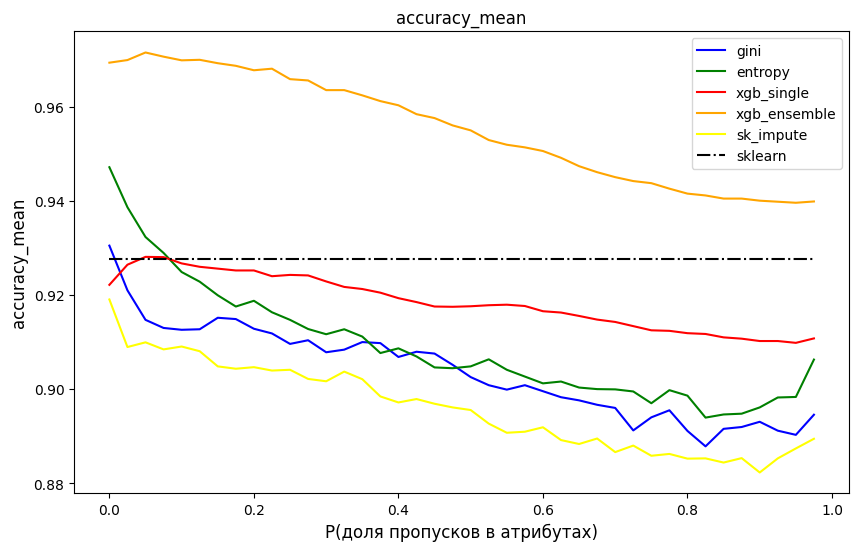

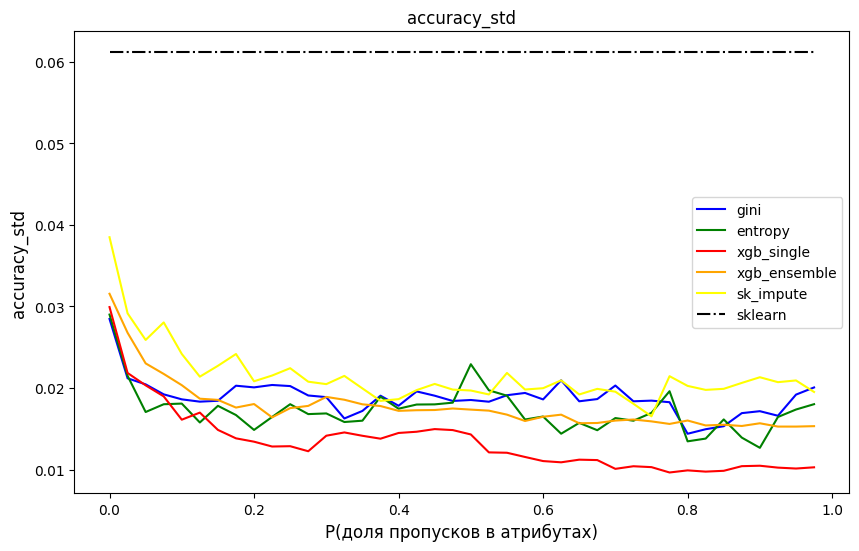

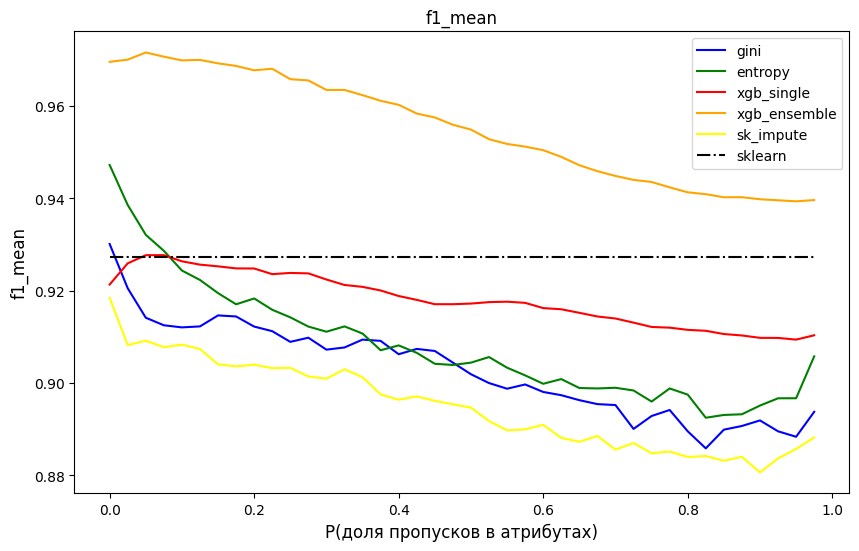

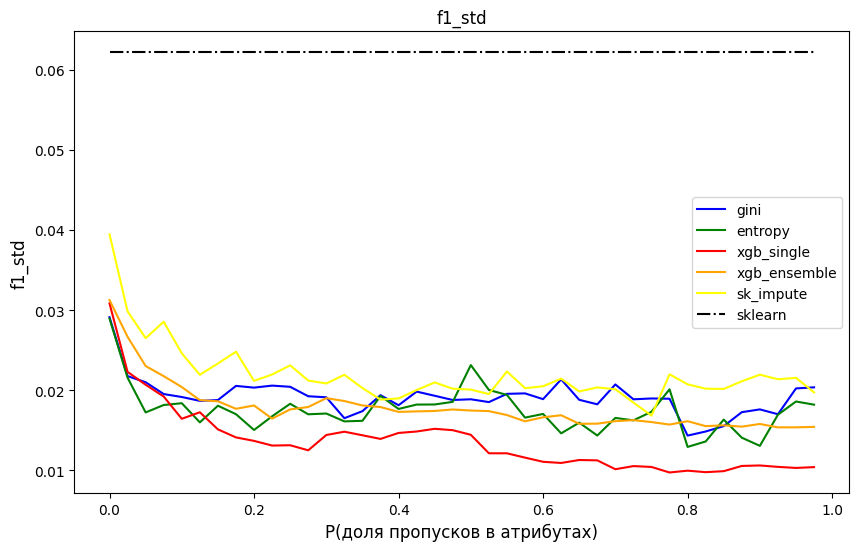

In [29]:
#the process of collecting metrics based on a large number of data partitions
config_ = {
    'seed': [1],
    'mod_flag': [True],
    'n_incomplete': [6],
    'n_pred': [3]
}
make_experiments(config_=config_, selection_m=10, n=50, multiple_missing_flag=False, missing_type="MCAR")

n_incomplete = 3, n_pred= 5, mod_flag = True


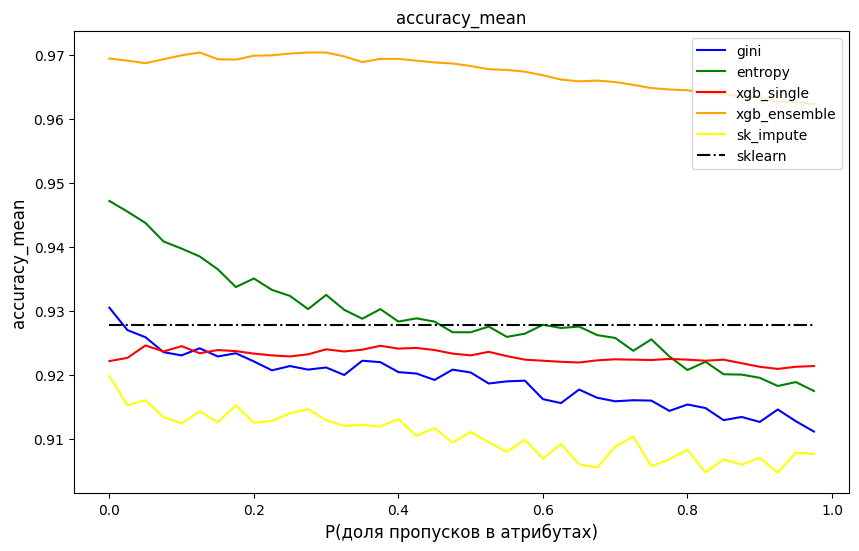

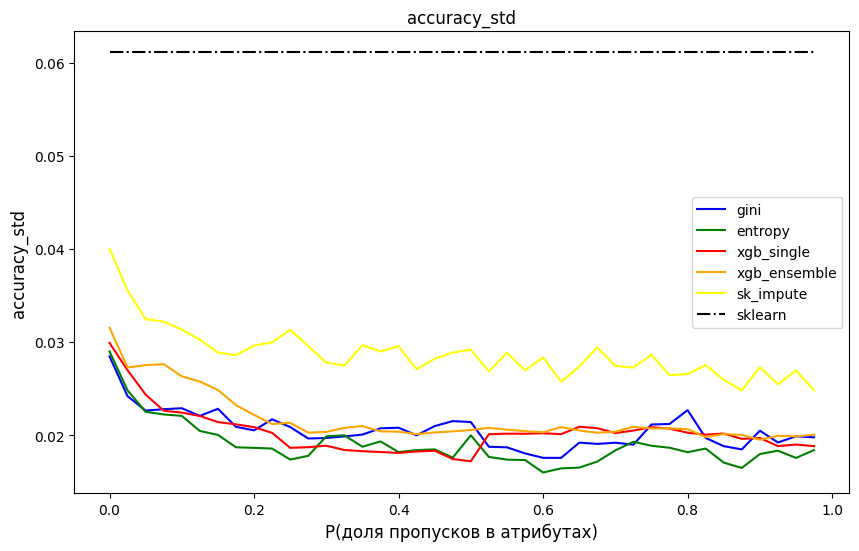

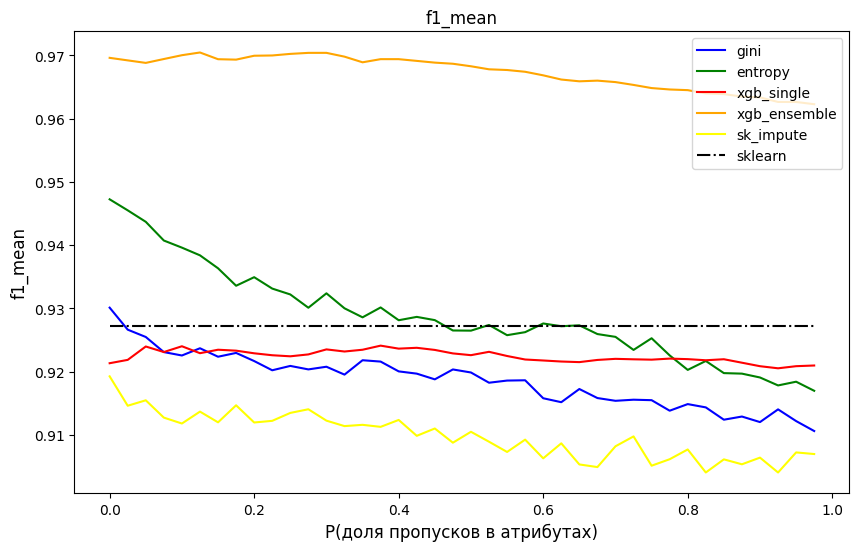

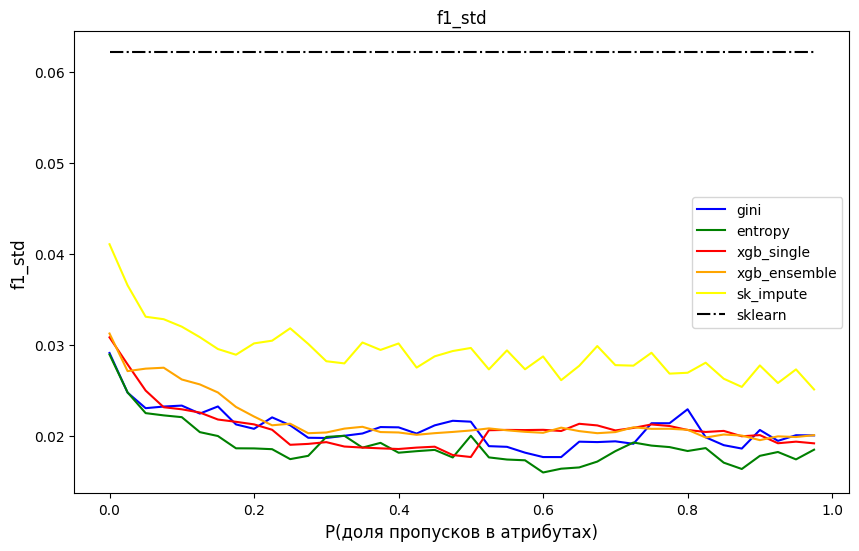

In [ ]:
#the process of collecting metrics based on a large number of data partitions
config_ = {
    'seed': [1],
    'mod_flag': [True],
    'n_incomplete': [3],
    'n_pred': [5]
}
make_experiments(config_=config_, selection_m=10, n=50, multiple_missing_flag=True, missing_type="MCAR")

## Результаты экспериментов(результаты описаны для критерия энтропии)

### Эксперимент 1
- **Критерий энтропии** более пригоден для использования.
- До **10%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **10%** пропущенных данных в атрибуте дерево работает лучше, чем дерево из **XGBoost**.
- В подавляющем большинстве случаев дерево работает лучше, чем импутация средним.
- Лучше предложенного метода работает только ансамбль из **100 деревьев** на небольшой доле пропусков.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

### Эксперимент 2
- **Критерий энтропии** более пригоден для использования.
- До **70%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **80%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- При небольшой доле пропусков лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

## Эксперименты с MAR пропусками

В данной секции проведем **7 экспериментов** с MAR пропусками и проанализируем результаты.

### Краткое описание экспериментов

1. **Простая зависимость пропусков в одном атрибуте от одного другого атрибута.**
2. **Простая зависимость одновременного пропуска трех атрибутов от трех атрибутов.**
3. **Простая зависимость одновременного пропуска пяти атрибутов от шести атрибутов.**
4. **Нелинейная (квадратичная) зависимость с весами одного признака от одного признака.**
5. **Нелинейная (квадратичная) зависимость с весами одновременного пропуска трех атрибутов от трех атрибутов.**
6. **Нелинейная (квадратичная) зависимость с весами одновременного пропуска пяти атрибутов от шести атрибутов.**
7. **Нелинейная (квадратичная) зависимость с весами от трех атрибутов, может быть пропущен любой из двух случайно выбранных атрибутов или оба сразу(несколько сценаривев)**

n_incomplete = 1, n_pred= 1, mod_flag = False


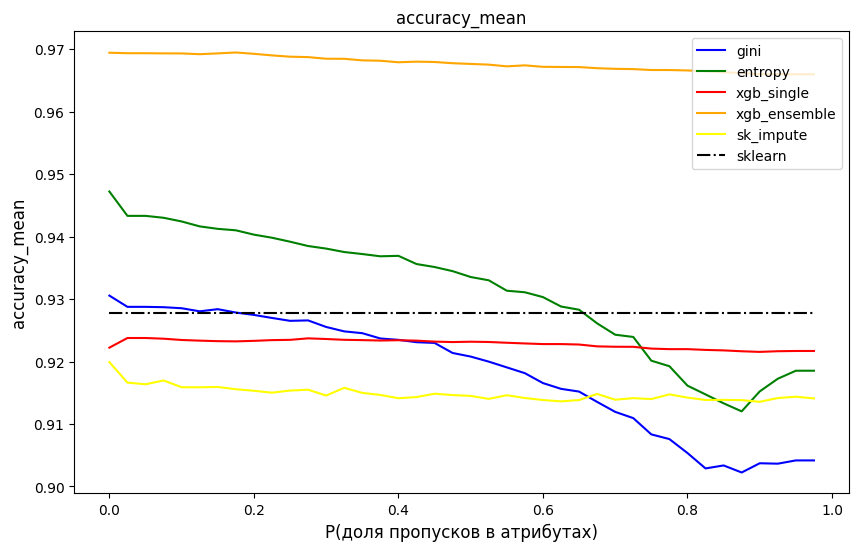

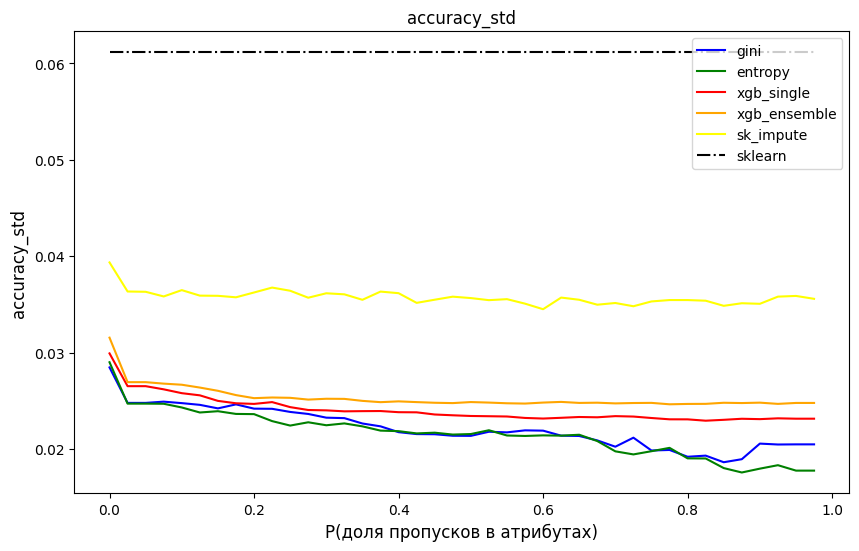

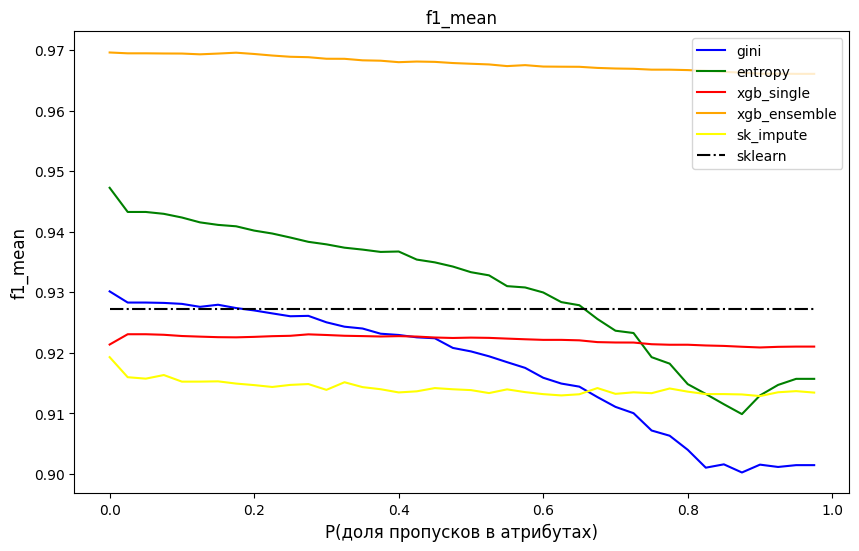

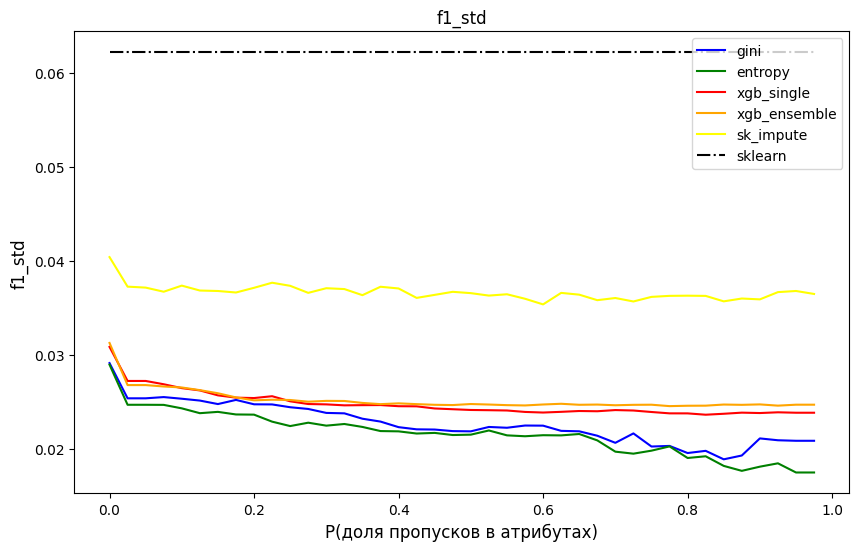

n_incomplete = 3, n_pred= 3, mod_flag = False


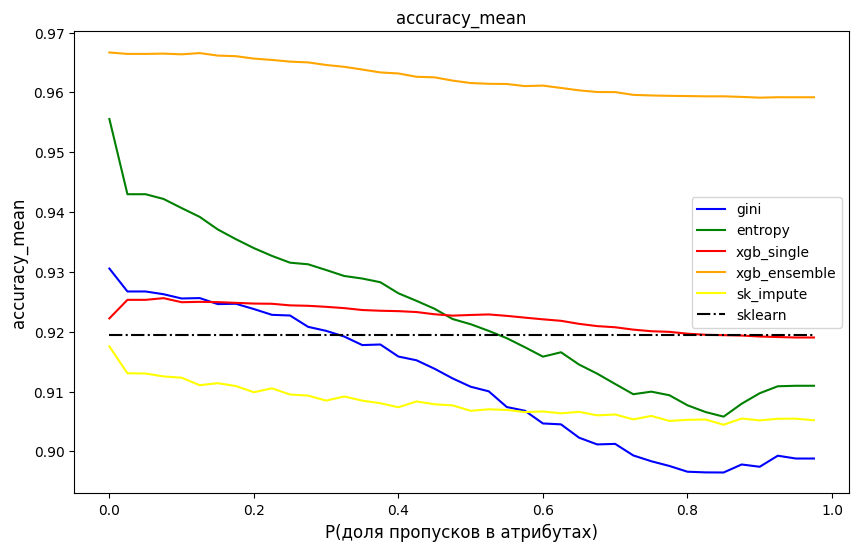

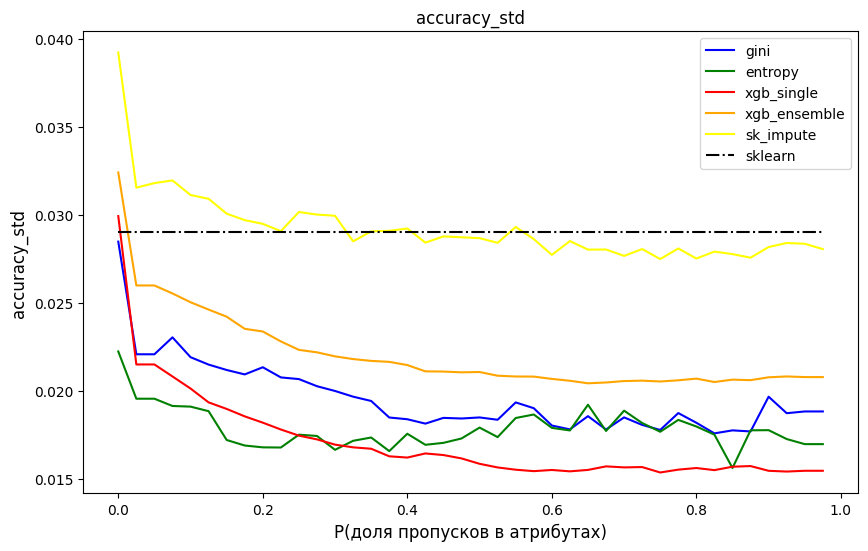

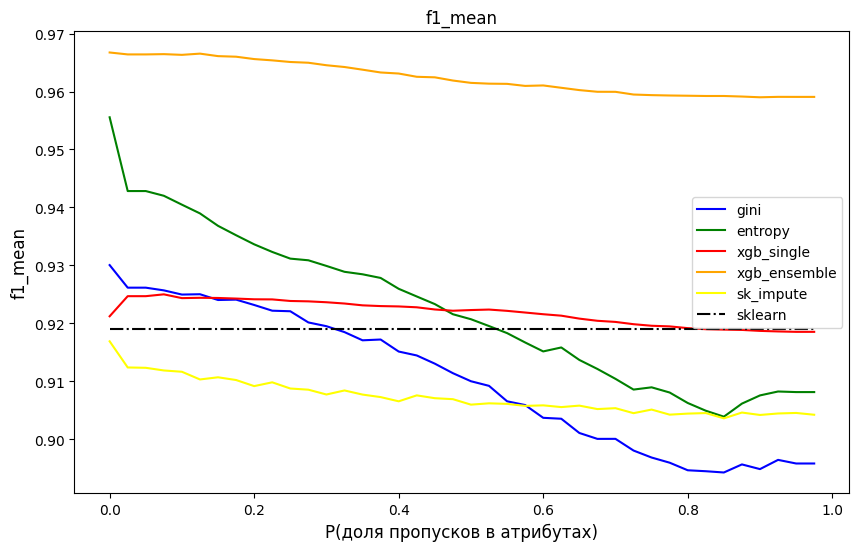

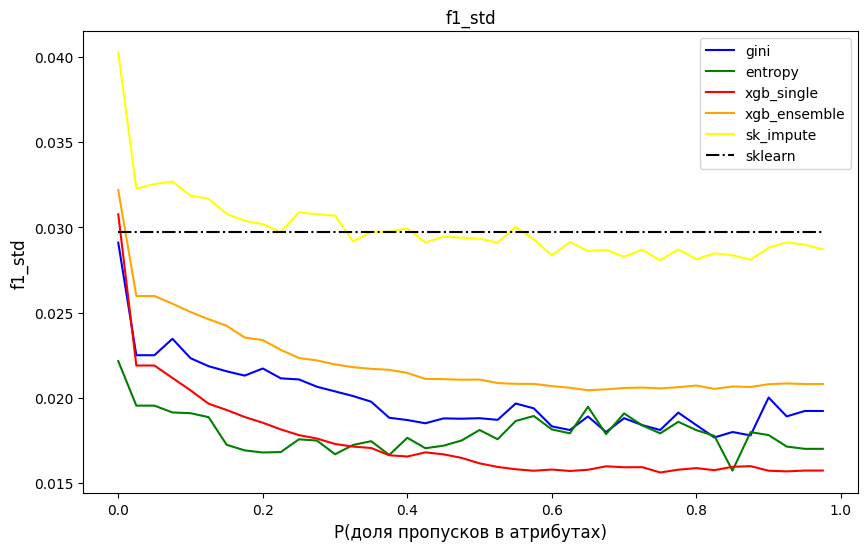

n_incomplete = 5, n_pred= 6, mod_flag = False


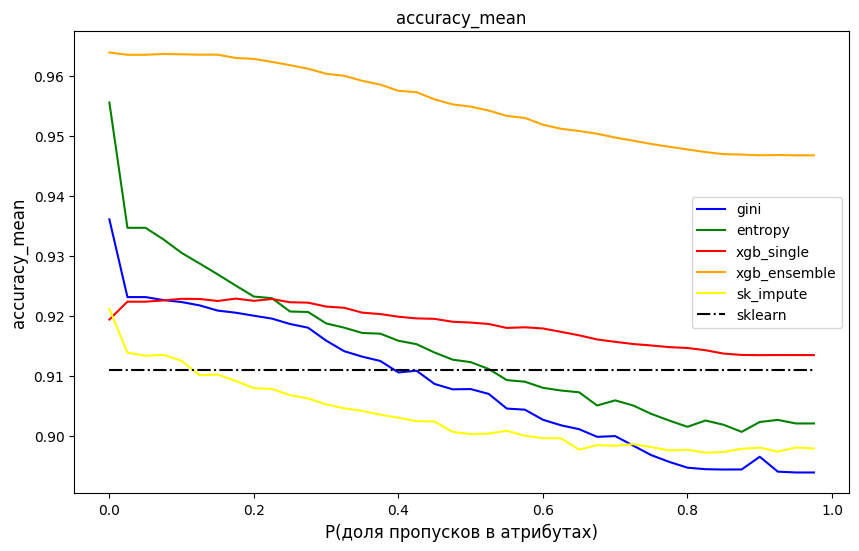

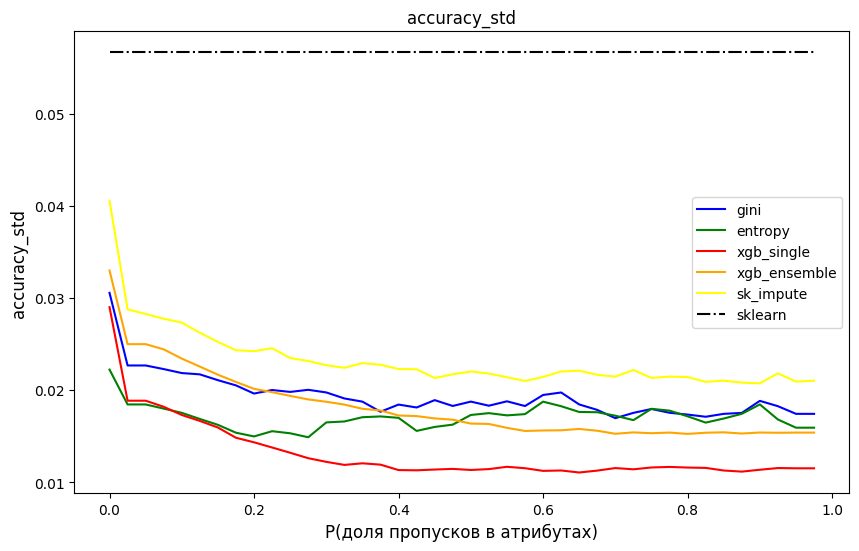

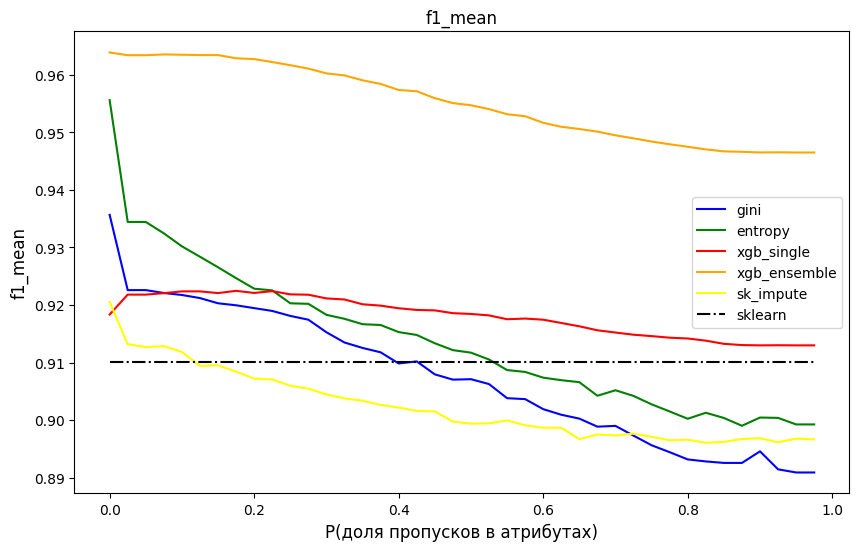

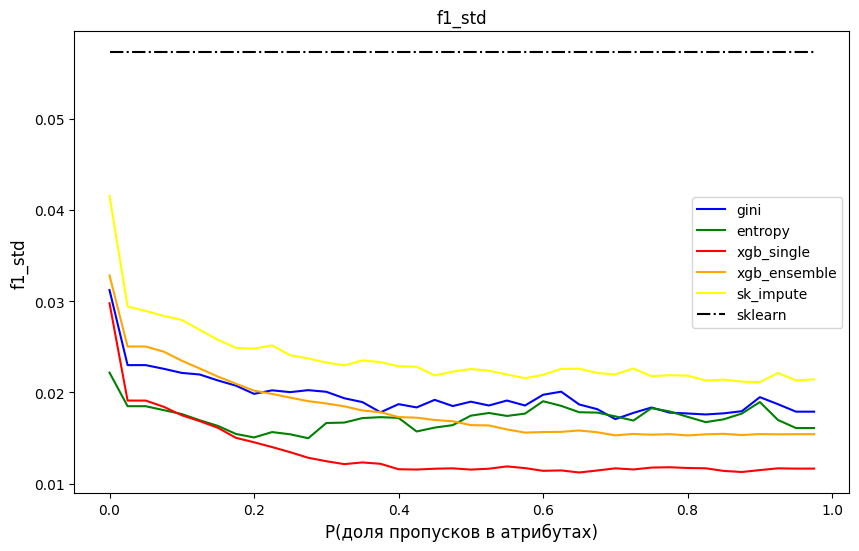

n_incomplete = 1, n_pred= 1, mod_flag = True


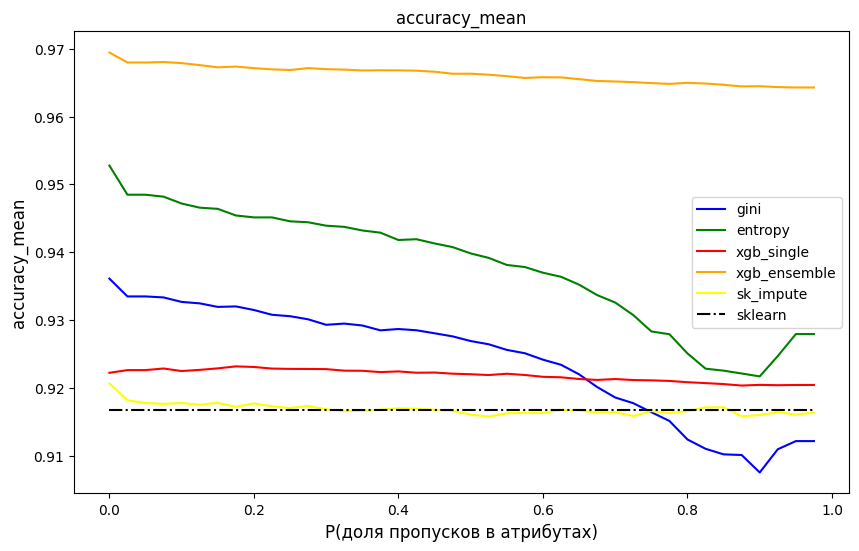

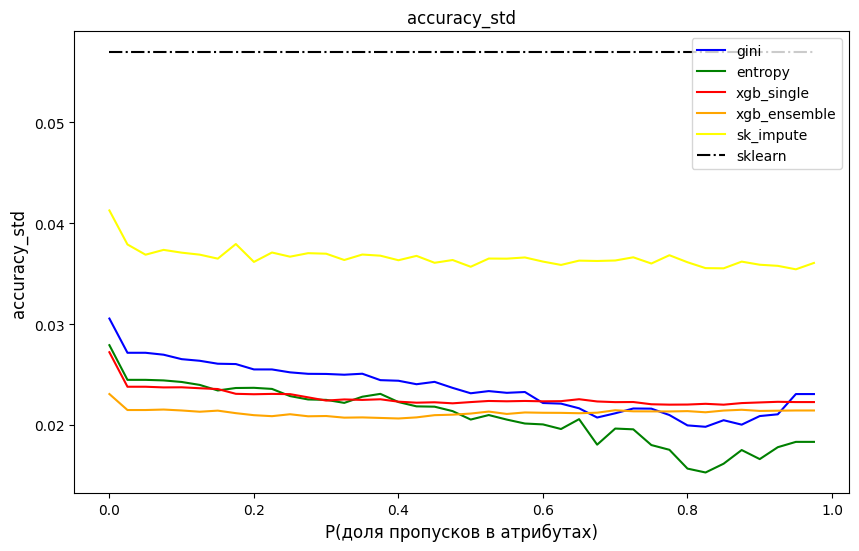

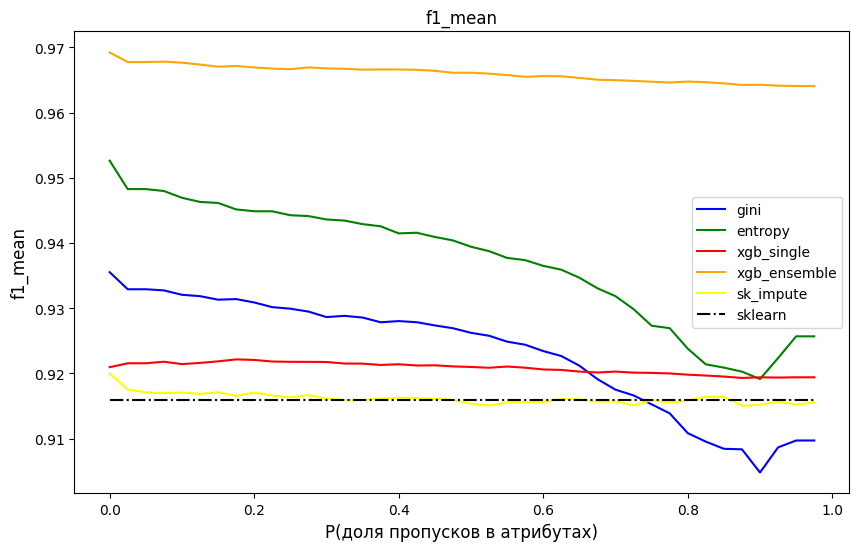

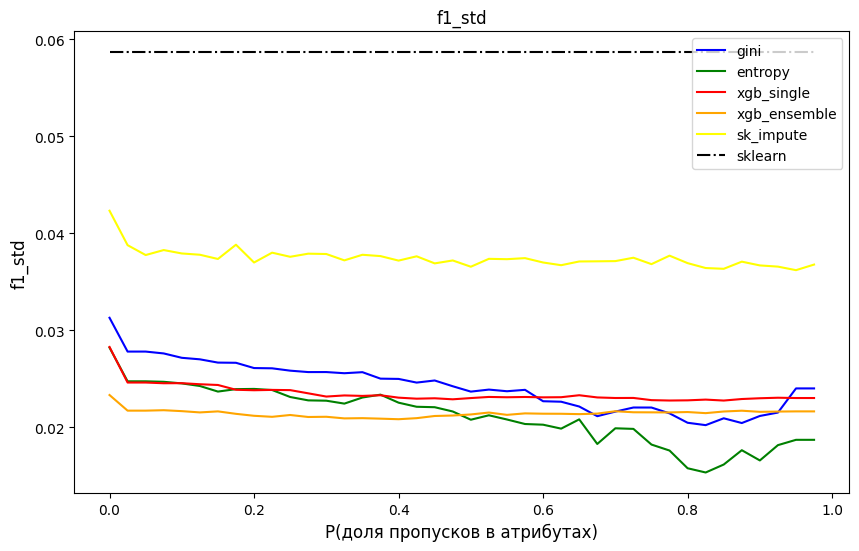

n_incomplete = 3, n_pred= 3, mod_flag = True


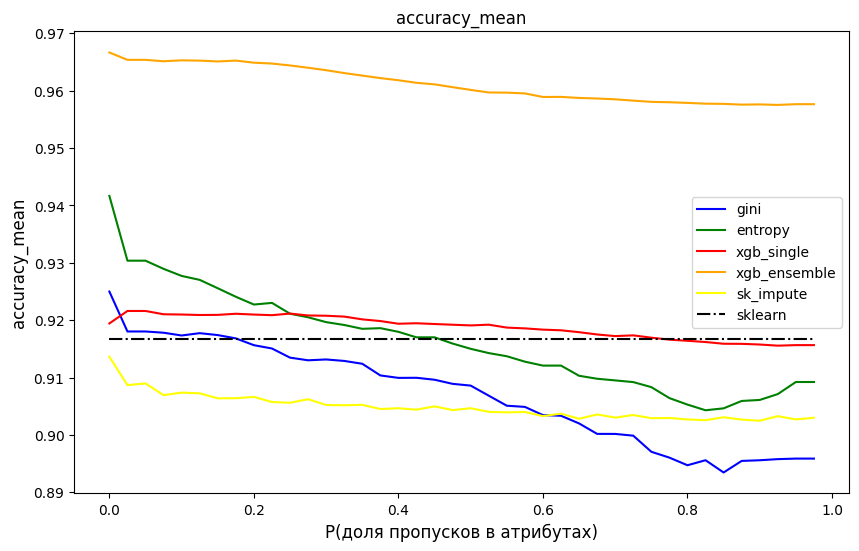

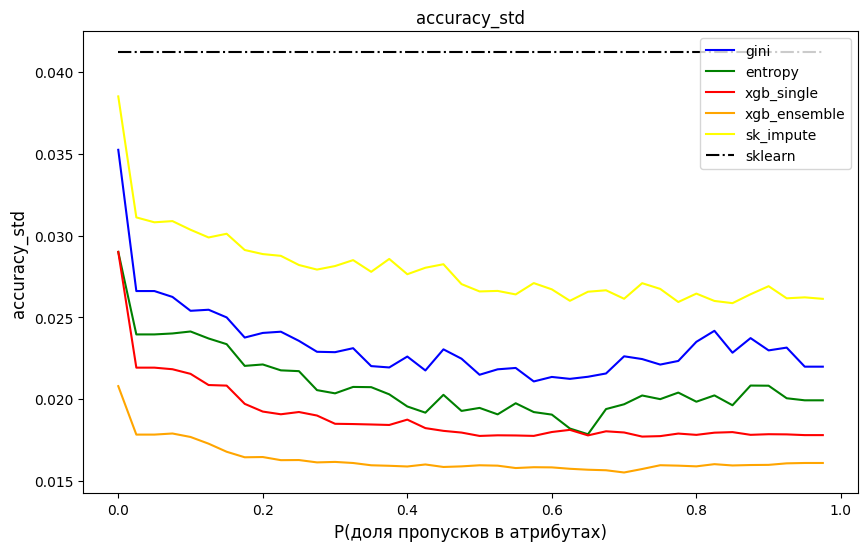

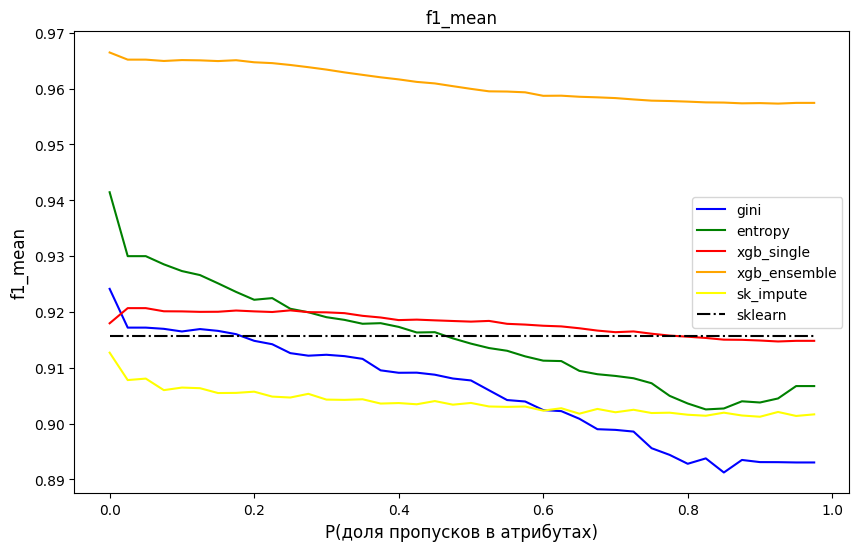

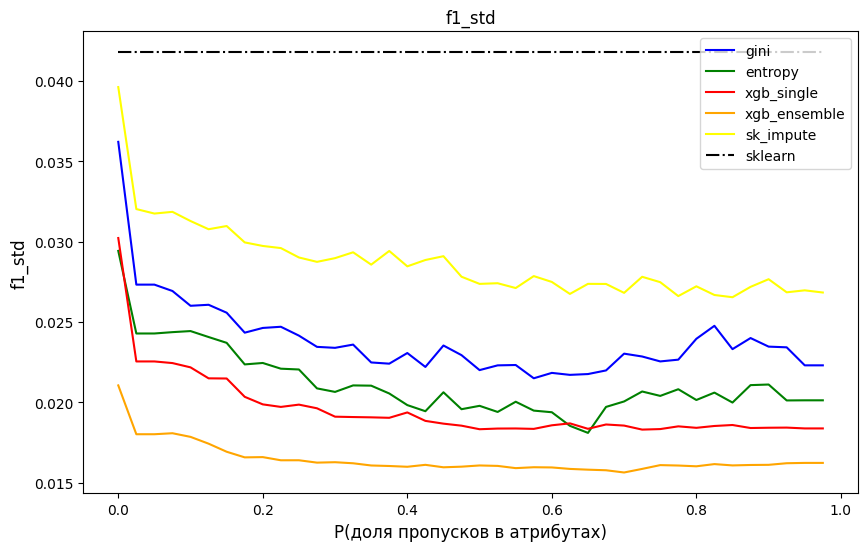

n_incomplete = 5, n_pred= 6, mod_flag = True


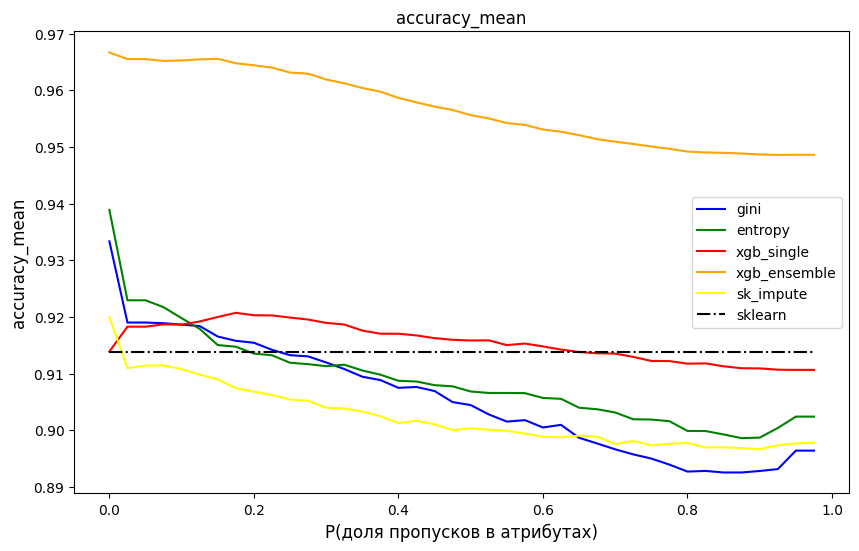

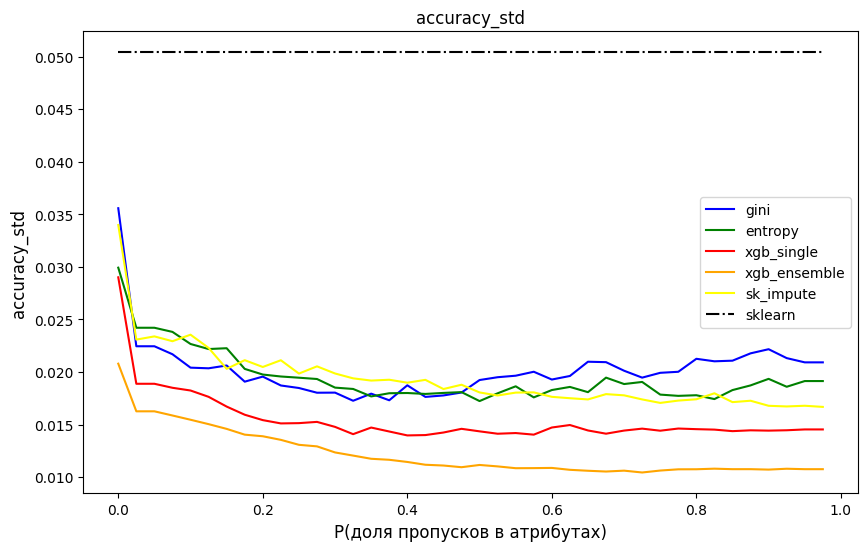

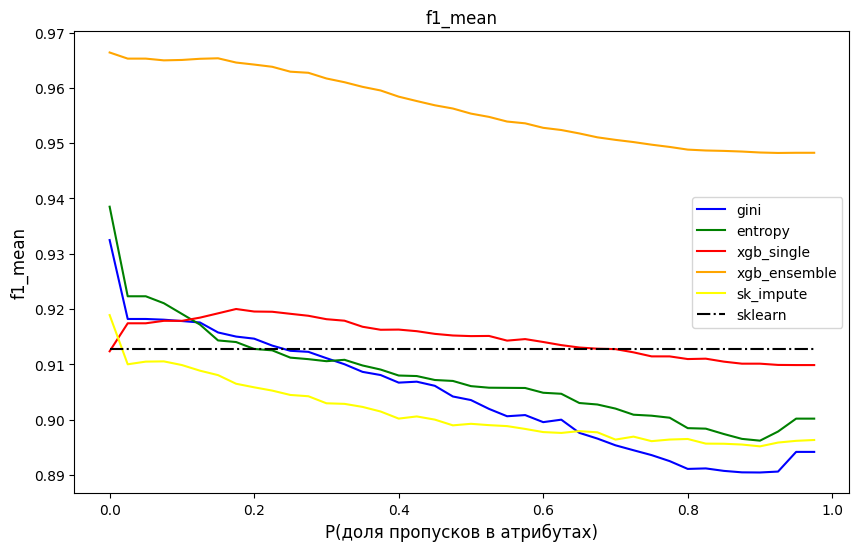

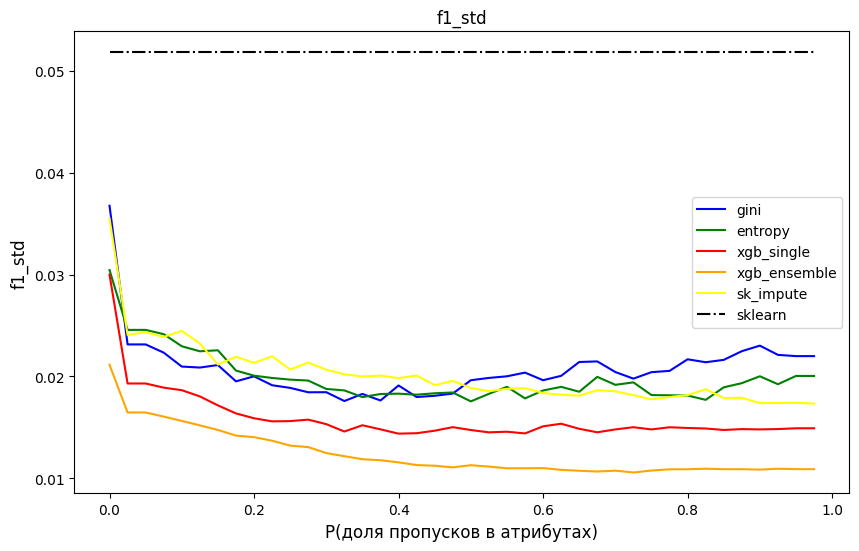

In [ ]:
#the process of collecting metrics based on a large number of data partitions
config = {
    'seed': [1, 2, 3, 4, 5, 6],
    'mod_flag': [False, False, False, True, True, True],
    'n_incomplete': [1, 3, 5, 1, 3, 5],
    'n_pred': [1, 3, 6, 1, 3, 6]
}
make_experiments(config_=config, selection_m=10, n=500, multiple_missing_flag=False, missing_type="MAR")

n_incomplete = 2, n_pred= 3, mod_flag = True


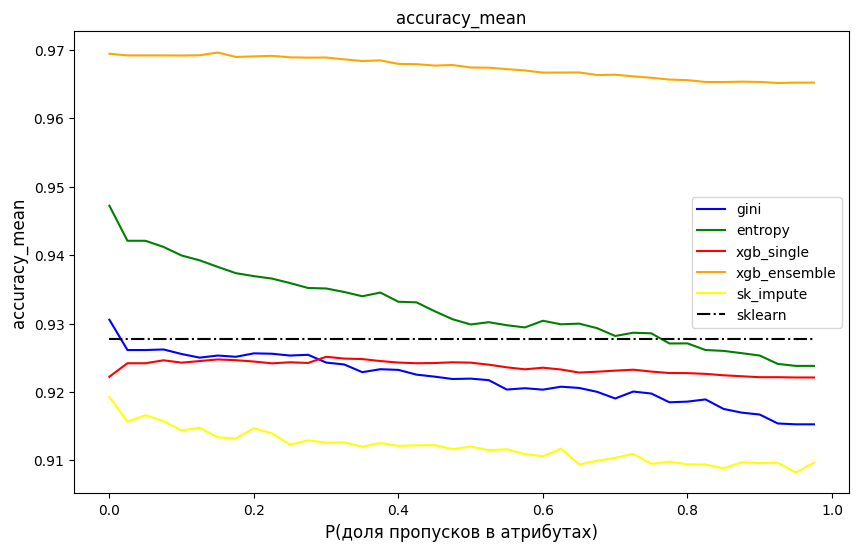

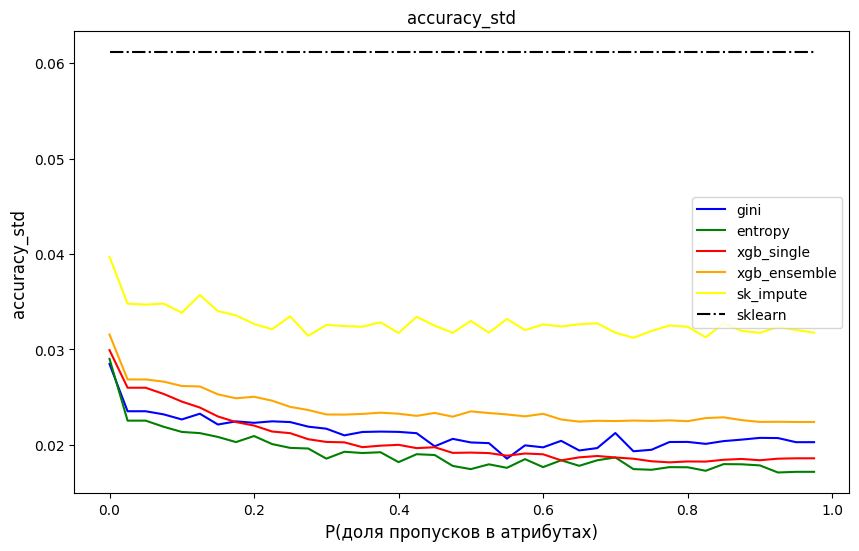

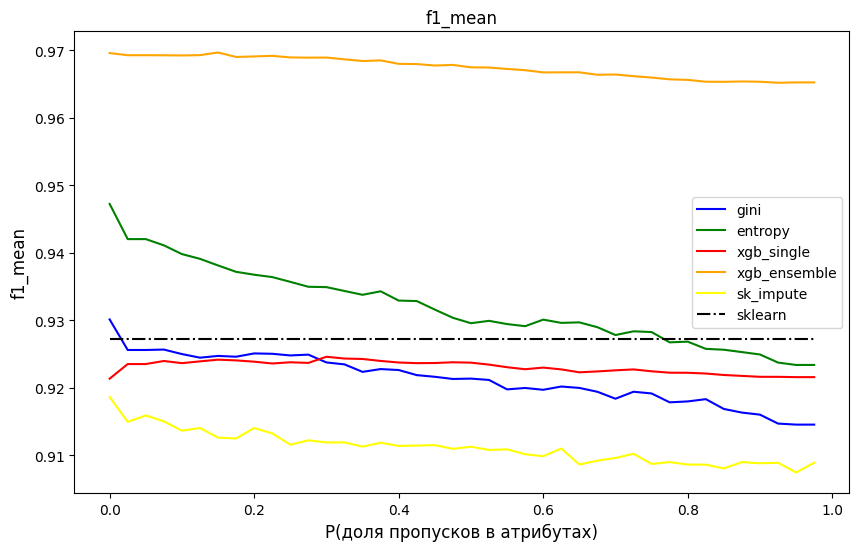

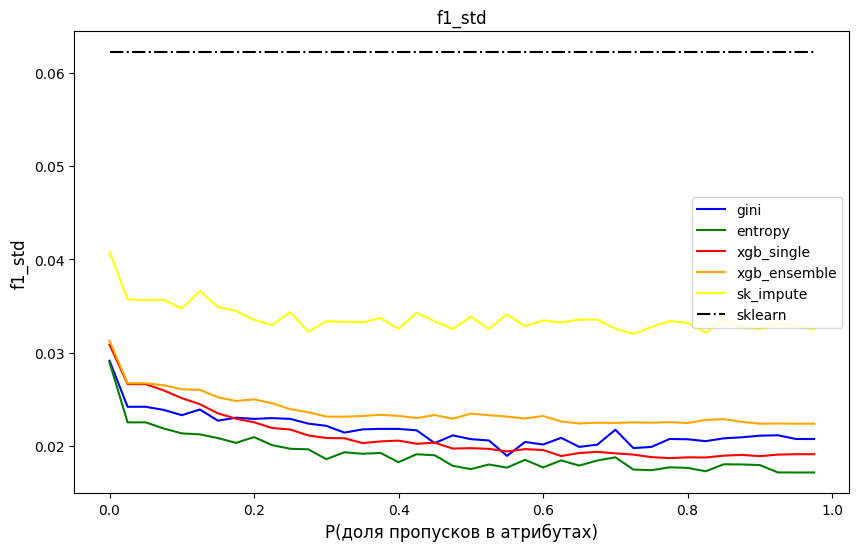

In [ ]:
#the process of collecting metrics based on a large number of data partitions
config_ = {
    'seed': [1],
    'mod_flag': [True],
    'n_incomplete': [2],
    'n_pred': [3]
}
make_experiments(config_=config_, selection_m=10, n=200, multiple_missing_flag=True, missing_type="MAR")

## Результаты экспериментов(результаты описаны для критерия энтропии)

### Эксперимент 1
- **Критерий энтропии** более пригоден для использования.
- До **70%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **75%** пропущенных данных в атрибуте дерево работает лучше, чем дерево из **XGBoost**.
- В подавляющем большинстве случаев дерево работает лучше, чем импутация средним.
- Лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

### Эксперимент 2
- **Критерий энтропии** более пригоден для использования.
- До **55%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **45%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- При небольшой доле пропусков лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

### Эксперимент 3
- **Критерий энтропии** более пригоден для использования.
- До **55%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **25%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- При небольшой доле пропусков лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

### Эксперимент 4
- **Критерий энтропии** более пригоден для использования.
- До **100%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **100%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- Лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

### Эксперимент 5
- **Критерий энтропии** более пригоден для использования.
- До **45%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **25%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- При небольшой доле пропусков лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

### Эксперимент 6
- **Критерий энтропии** более пригоден для использования.
- До **25%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **15%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- При небольшой доле пропусков лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае, так как точность на тестовой выборке не падает ниже **0.9**.

### Эксперимент 7
- **Критерий энтропии** более пригоден для использования.
- До **75%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **100%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- Лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

## Эксперименты с MNAR пропусками

В данной секции проведем **2 эксперимента** с MNAR пропусками и проанализируем результаты.

### Краткое описание экспериментов

1. **Случайный одновременный пропуск в 6 атрибутах**
2. **Случайный пропуск в случайной комбинации от 1 до 3 атрибутов для трех случайно выбранных атрибутов**

n_incomplete = 6, n_pred= 0, mod_flag = True


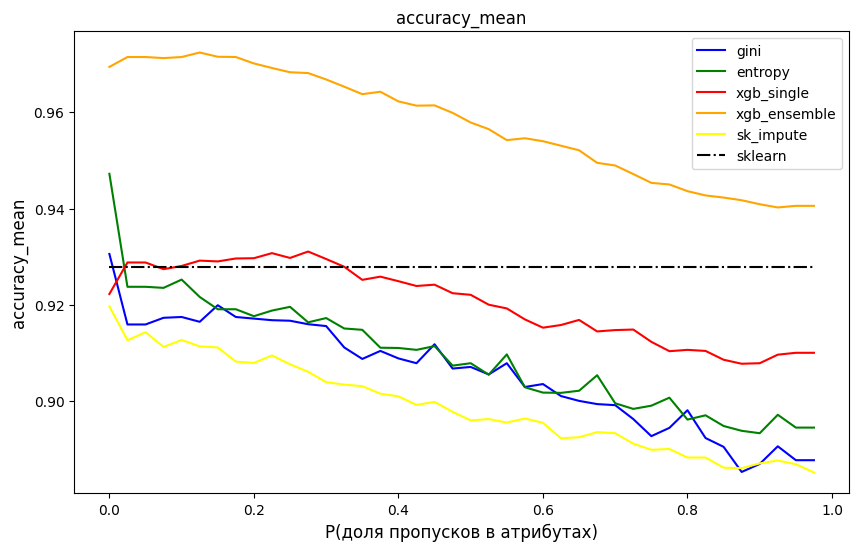

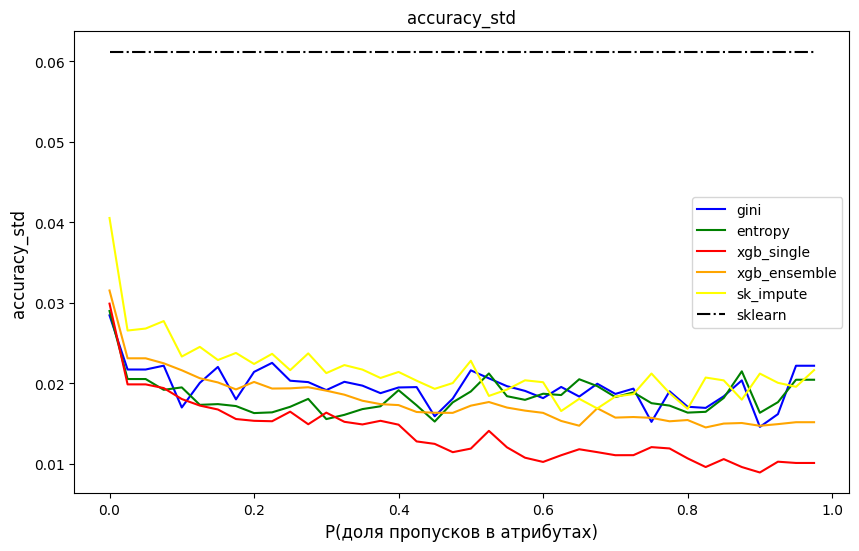

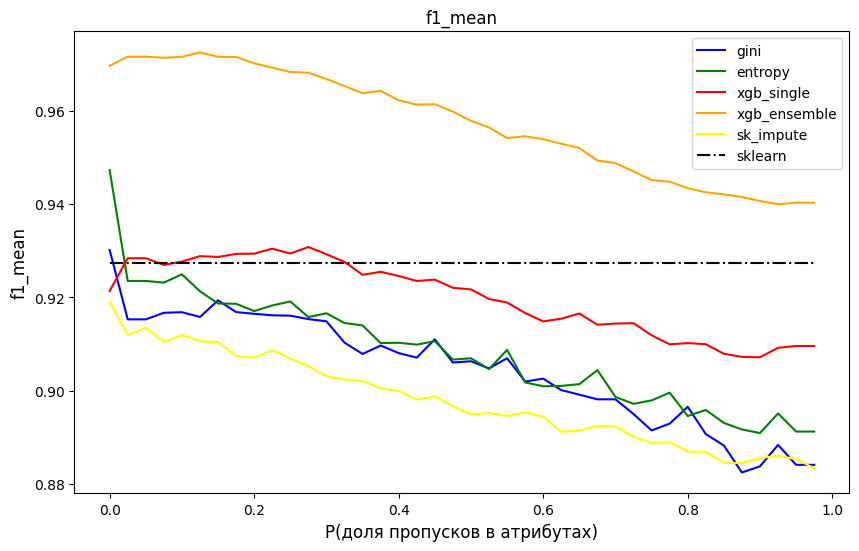

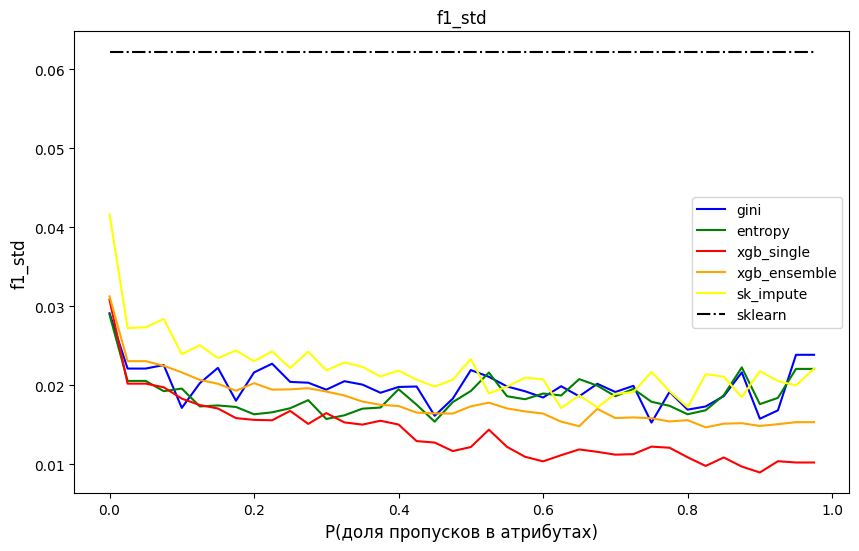

In [ ]:
#the process of collecting metrics based on a large number of data partitions
config_ = {
    'seed': [1],
    'mod_flag': [True],
    'n_incomplete': [6],
    'n_pred': [0]
}
make_experiments(config_=config_, selection_m=10, n=50, multiple_missing_flag=False, missing_type="MNAR")

n_incomplete = 3, n_pred= 0, mod_flag = True


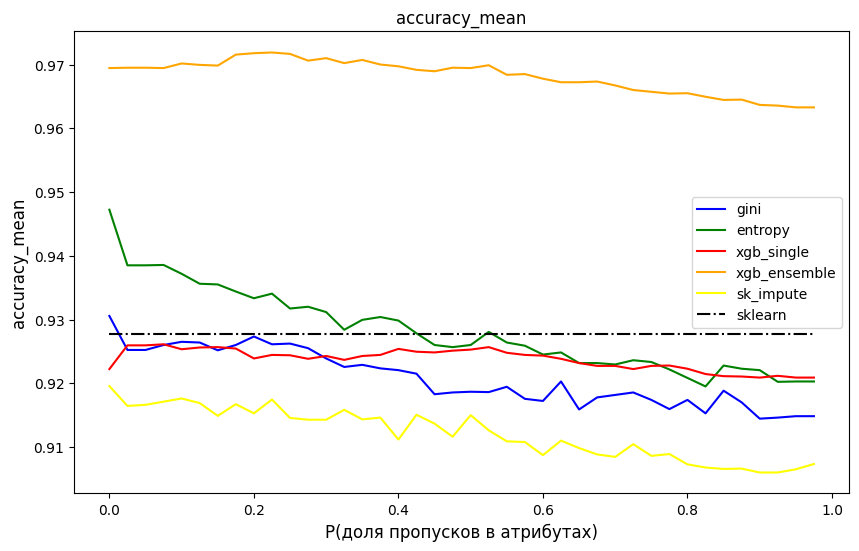

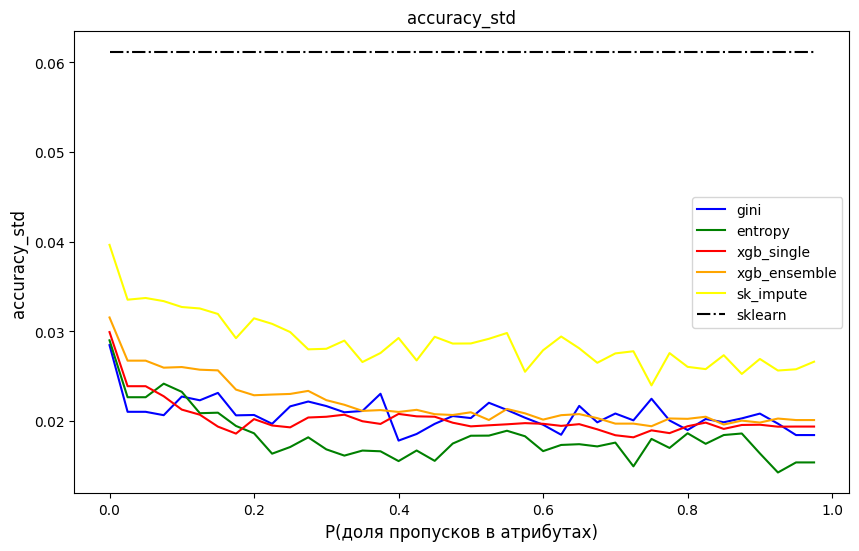

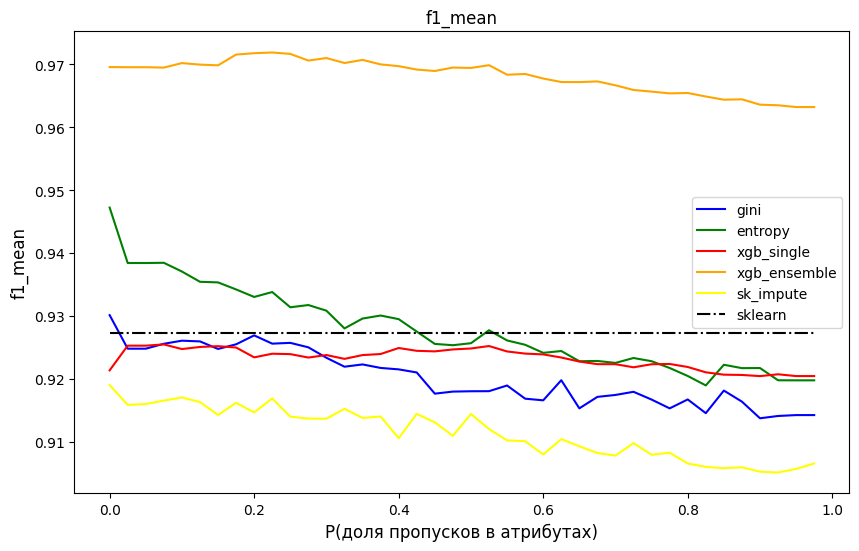

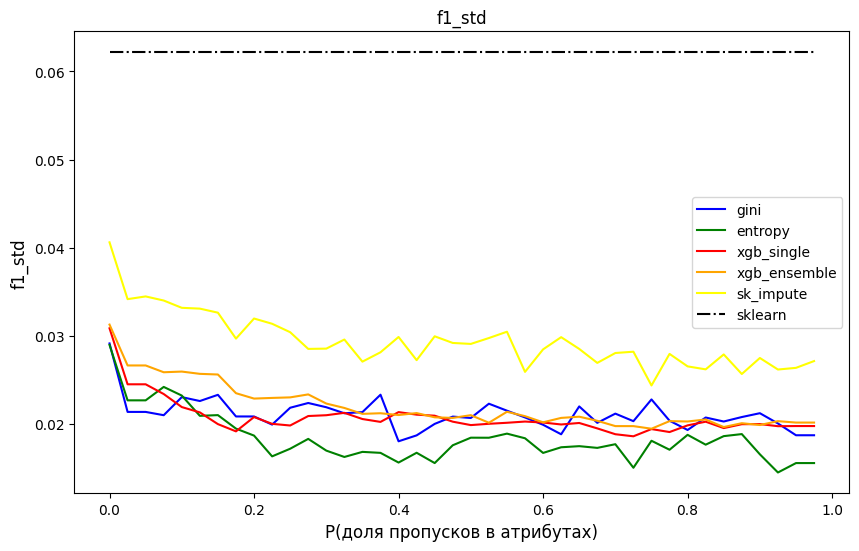

In [ ]:
#the process of collecting metrics based on a large number of data partitions
config_ = {
    'seed': [1],
    'mod_flag': [True],
    'n_incomplete': [3],
    'n_pred': [0]
}
make_experiments(config_=config_, selection_m=10, n=50, multiple_missing_flag=True, missing_type="MNAR")

## Результаты экспериментов(результаты описаны для критерия энтропии)

### Эксперимент 1
- **Критерий энтропии** более пригоден для использования.
- Дерево не работает лучше xgb или дерава на данных без пропусков при наличии пропусков в данном случае.
- В подавляющем большинстве случаев дерево работает лучше, чем импутация средним.

### Эксперимент 2
- **Критерий энтропии** более пригоден для использования.
- До **45%** пропущенных данных в атрибутах дерево работает лучше, чем дерево на полных данных.
- До **100%** пропущенных данных в атрибутах дерево работает лучше, чем дерево из **XGBoost**.
- При любой доле пропусков дерево работает лучше, чем импутация средним.
- При небольшой доле пропусков лучше предложенного метода работает только ансамбль из **100 деревьев**.
- Относительно низкое стандартное отклонение и большое количество экспериментов позволяют считать данные достоверными. Дерево пригодно для использования в данном случае.

___

## Вывод

Предложенный вероятностный подход к обработке данных с пропусками продемонстрировал высокую эффективность и точность при использовании как **критерия Джини**, так и **критерия энтропии**. Его применение оправдано в определённых условиях, которые зависят от структуры данных и характера пропусков.

### Когда стоит использовать подход
- **При большом количестве атрибутов**: На датасетах с достаточным числом признаков, таких как датасет вин (13 атрибутов), подход показывает стабильно лучшие результаты по сравнению с методом импутации средним. В зависимости от доли пропусков и числа пропущенных атрибутов, он превосходит как дерево из библиотеки **scikit-learn** на полных данных, так и реализацию дерева из **XGBoost** до определённого порога пропусков.
- **Устойчивость к сложным зависимостям**: Подход эффективен даже при нелинейных и сложных зависимостях пропусков, что делает его универсальным инструментом для обработки данных.

### Ограничения подхода
- **При малом количестве атрибутов**: Тестирование на датасете ирисов (с двумя ключевыми атрибутами) показало, что при пропусках в одном из них точность резко падает. В таких случаях подход уступает как импутации средним, так и решениям из **XGBoost**.
- **Сравнение с ансамблями**: Вероятностный подход работает хуже ансамбля деревьев решений (например, из 100 деревьев), хотя требует значительно меньше вычислительных ресурсов для обучения и предсказания.

### Преимущества подхода
- **Высокая точность**: При использовании критерия энтропии результаты стабильно лучше импутации средним, а в ряде случаев — лучше деревьев на полных данных и **XGBoost**.
- **Эффективность**: Меньшая вычислительная сложность по сравнению с ансамблями делает подход практичным выбором для задач с ограниченными ресурсами.
- **Гибкость**: Возможность работы с различными типами пропусков, включая сложные и нелинейные зависимости.

### Итоговая рекомендация
Предложенный вероятностный подход хорошо зарекомендовал себя и может быть успешно использован для обработки данных с пропусками при условии наличия **достаточного количества атрибутов** (например, 10 и более). Он особенно полезен в сценариях, где важна устойчивость к сложным зависимостям пропусков и ограничены вычислительные ресурсы. В случаях с малым числом атрибутов или приоритетности максимальной точности стоит рассмотреть альтернативные методы. Таким образом, предложенная реализация является одним из эффективных вариантов для работы с данными, содержащими пропуски.